In [1]:
import plot_utils as u
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from tqdm.notebook import tqdm

In [2]:
results_dir = Path('long_pi_grid')
tail_lengths = [1000, 2000, 5000, 10000, 15000, 20000]
line_colors = ['#dcc48e', '#eaefd3', '#b3c0a4', '#505168', '#27233a', '#561f37', '#b3c0a4', '#505168', '#27233a']
setpoint = 1.0414E-4
lam = 1e-9

In [3]:
def compute_fitness(results_dir, lam):
    results = dict()
    for tl in tail_lengths:
        results[tl] = []
    for d in tqdm(list(results_dir.iterdir())):
        if not d.is_dir():
            continue
        for output_file in d.glob('*.out'):
            config = u.read_config_from_output_file(output_file)
        controller_t, controller_p, controller_b = u.load_controller_data(d)
        controller_e = (controller_b - config['setpoint']) / config['setpoint']
        # lfp_time, lfp_voltage = u.load_stn_lfp(d)
        
        dt = controller_t[1] = controller_t[0]
        
        for tl in tail_lengths:
            
            num_samples = int(tl / dt)
            j = np.sum((controller_e[-num_samples:]) ** 2 + lam * (controller_p[-num_samples:] ** 2)) / (2 * num_samples)
            
            mse = np.sum((controller_b[-num_samples:] - setpoint) ** 2) / (2 * num_samples)
            teed = np.sum(controller_p[-num_samples:] ** 2) / (2 * num_samples)
            # teed = u.compute_teed(controller_t, controller_p, 80, 130, 1)
            results[tl].append((config['ti'], config['kp'], mse, teed, j))
    return results

In [4]:
def plot_fitness_slice(results, plotted, ti, lam, i_lam, prefix=None):
    tail_lengths_display = [1000, 2000, 5000, 10000, 15000, 20000]
    display_colours = line_colors

    fig = plt.figure(figsize=(15, 12))
    if plotted == 'fitness':
        plot_title = f'Ti = {ti} {plotted} plot (lambda={lam})'
    else:
        plot_title = f'Ti = {ti} {plotted} plot'

    for i, tld in enumerate(tail_lengths_display):
        dtypes = [('ti', float), ('kp', float), ('mse', float), ('teed', float), ('j', float)]
        a = np.array(results[tld], dtype=dtypes)
        a.sort(order=['ti', 'kp'])

        xx = [e[1] for e in a if e[0] == ti]
        mse = np.array([e[2] for e in a if e[0] == ti])
        teed = np.array([e[3] for e in a if e[0] == ti])
        j = np.array([e[4] for e in a if e[0] == ti])
        
        if plotted == 'MSE':
            plt.plot(xx, mse, color=display_colours[i])
        elif plotted == 'TEED':
            plt.plot(xx, teed, color=display_colours[i])
        elif plotted == 'fitness':
            plt.plot(xx, j, color=display_colours[i])

    u.format_single_2d_plot(fig, xlabel='Kp', ylabel=f'{plotted}', title=plot_title)
    if prefix is None:
        plt.savefig(f'{plotted}_slice_ti_{ti}_lambda_{i_lam}_{lam}.png', facecolor='white', bbox_inches='tight')
    else:
        plt.savefig(f'{prefix}_{plotted}_slice_ti_{ti}_lambda_{i_lam}_{lam}.png', facecolor='white', bbox_inches='tight')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

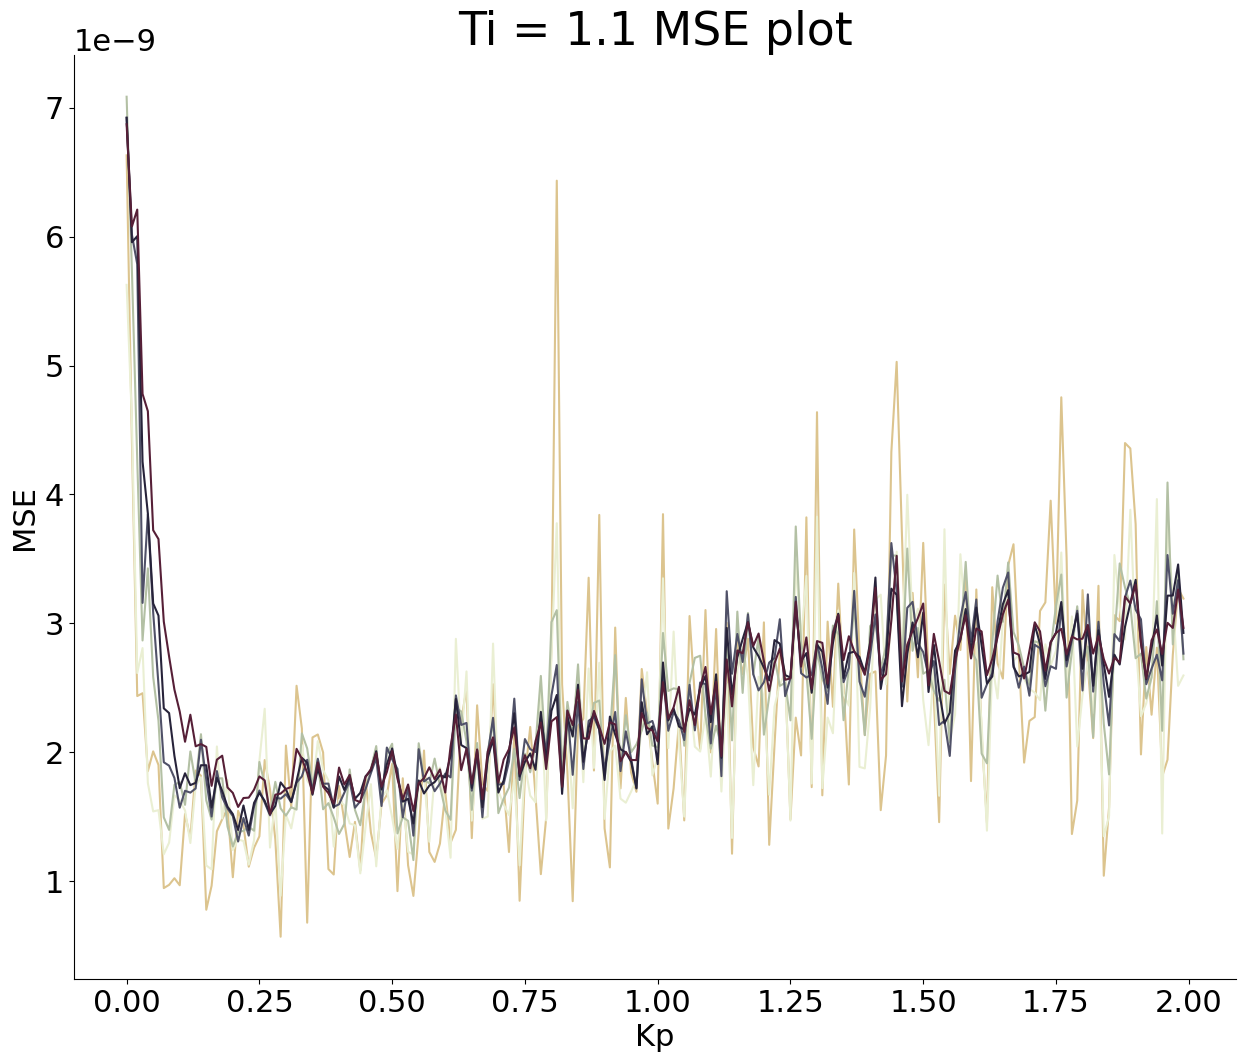

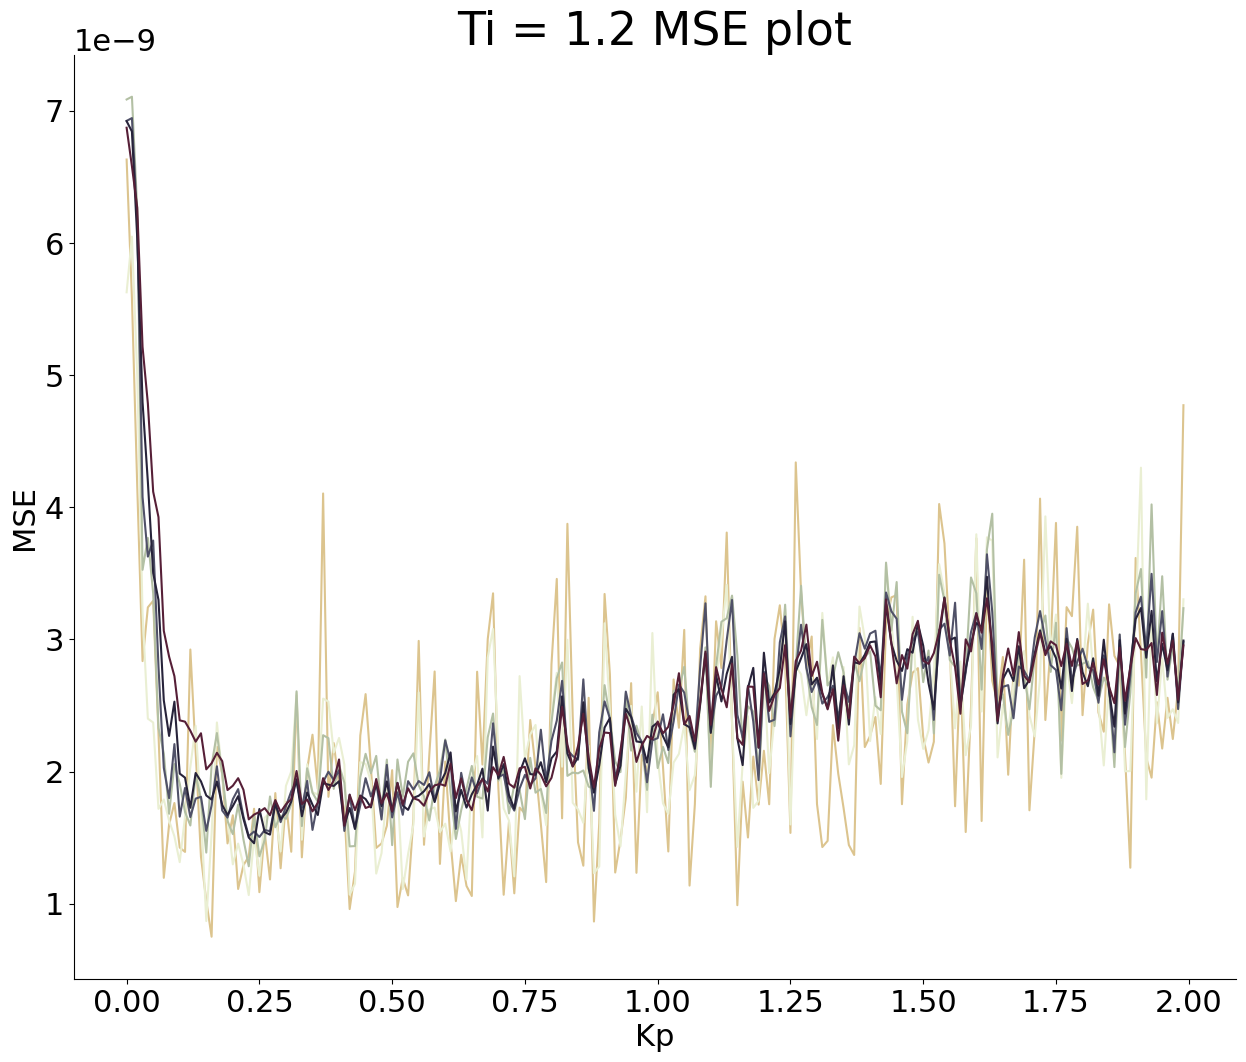

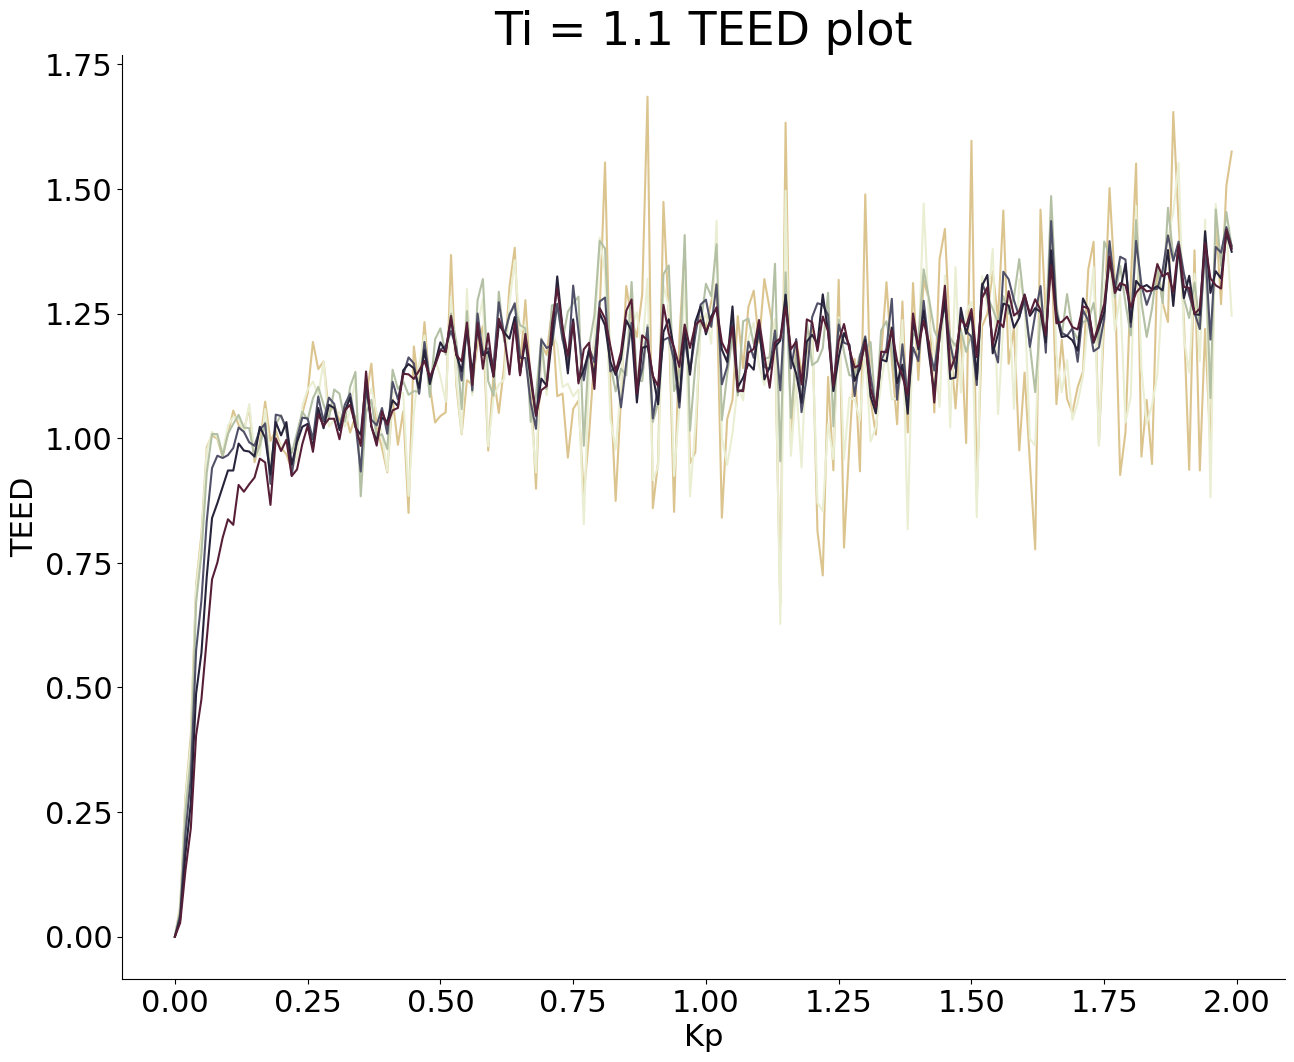

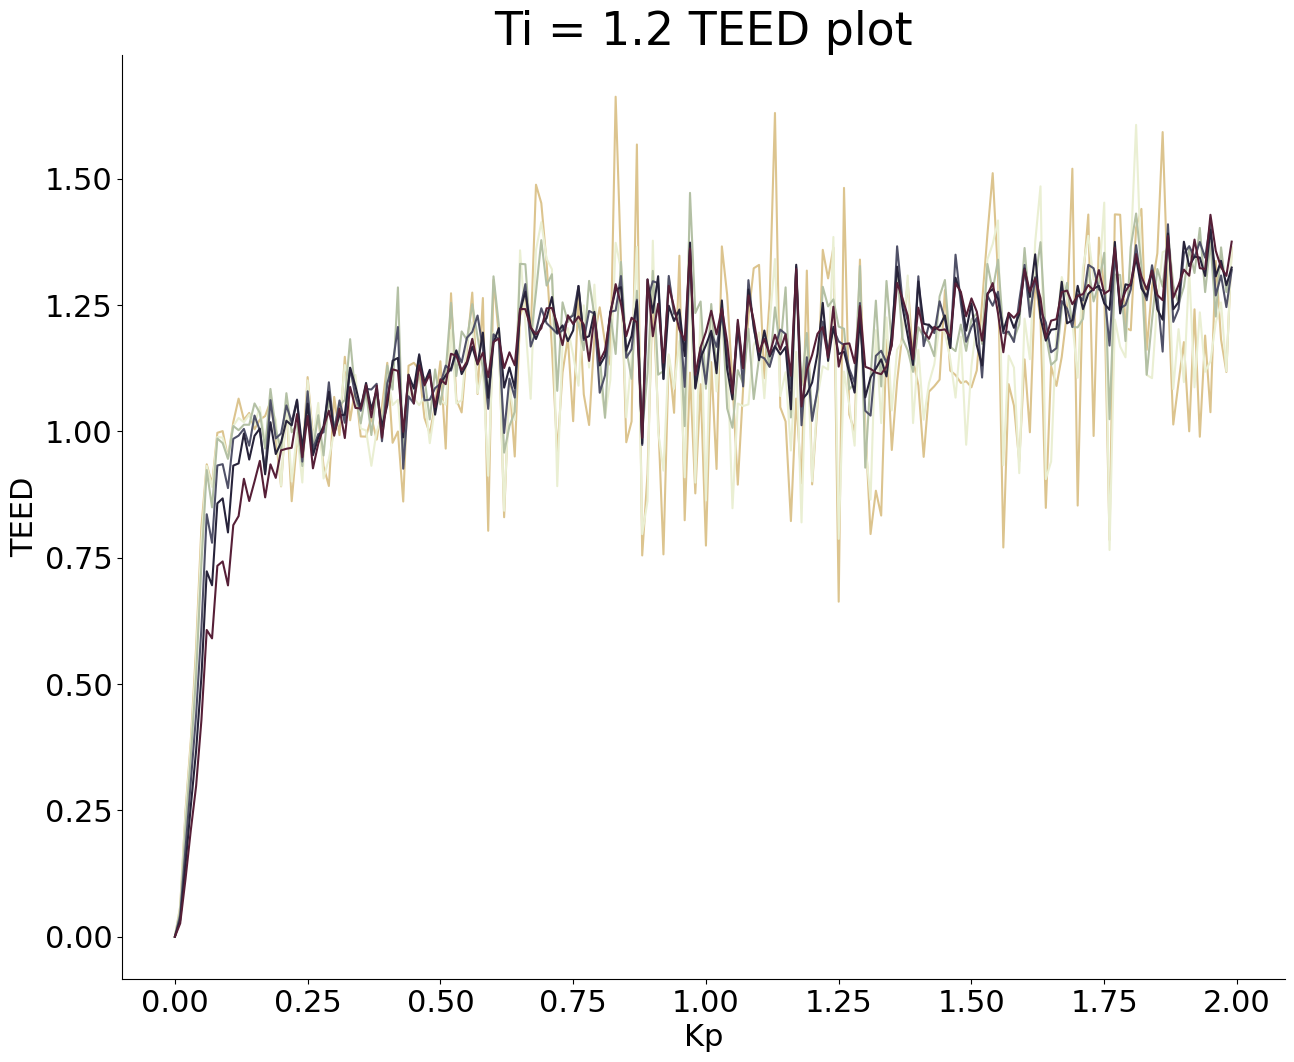

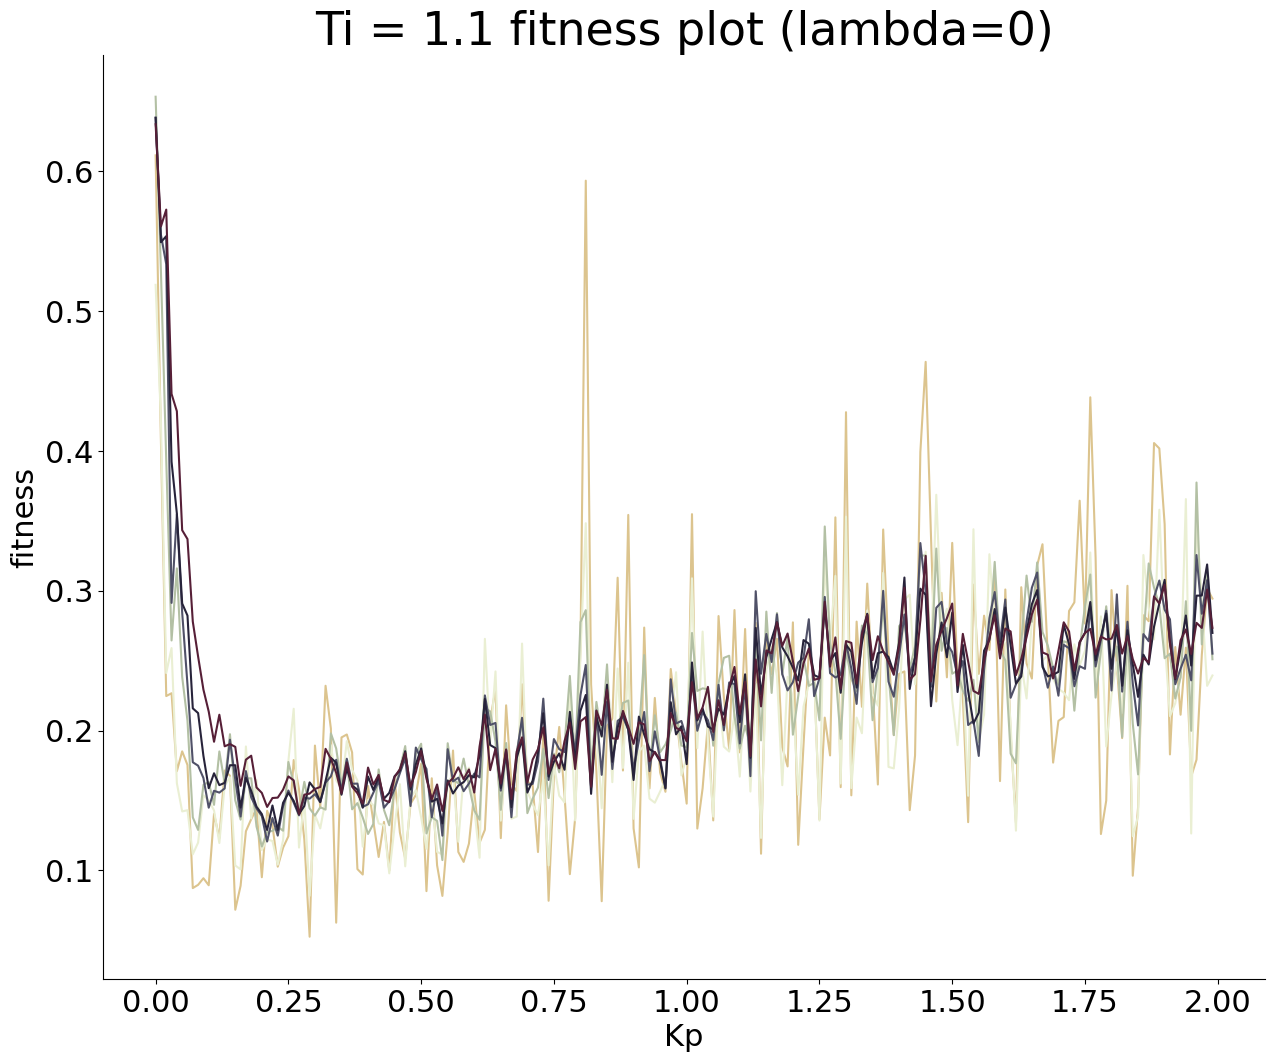

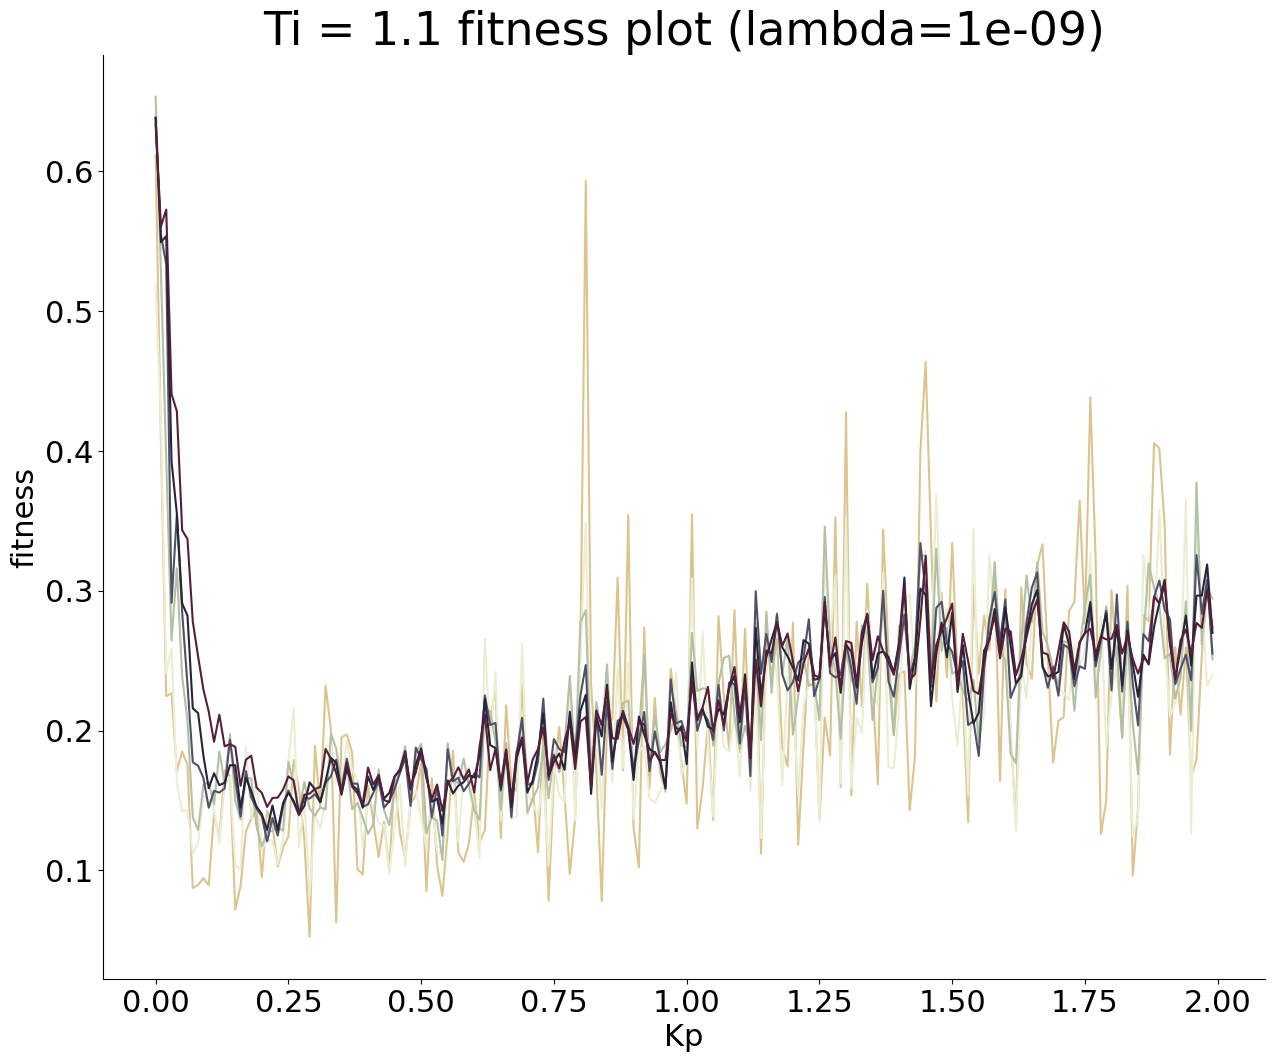

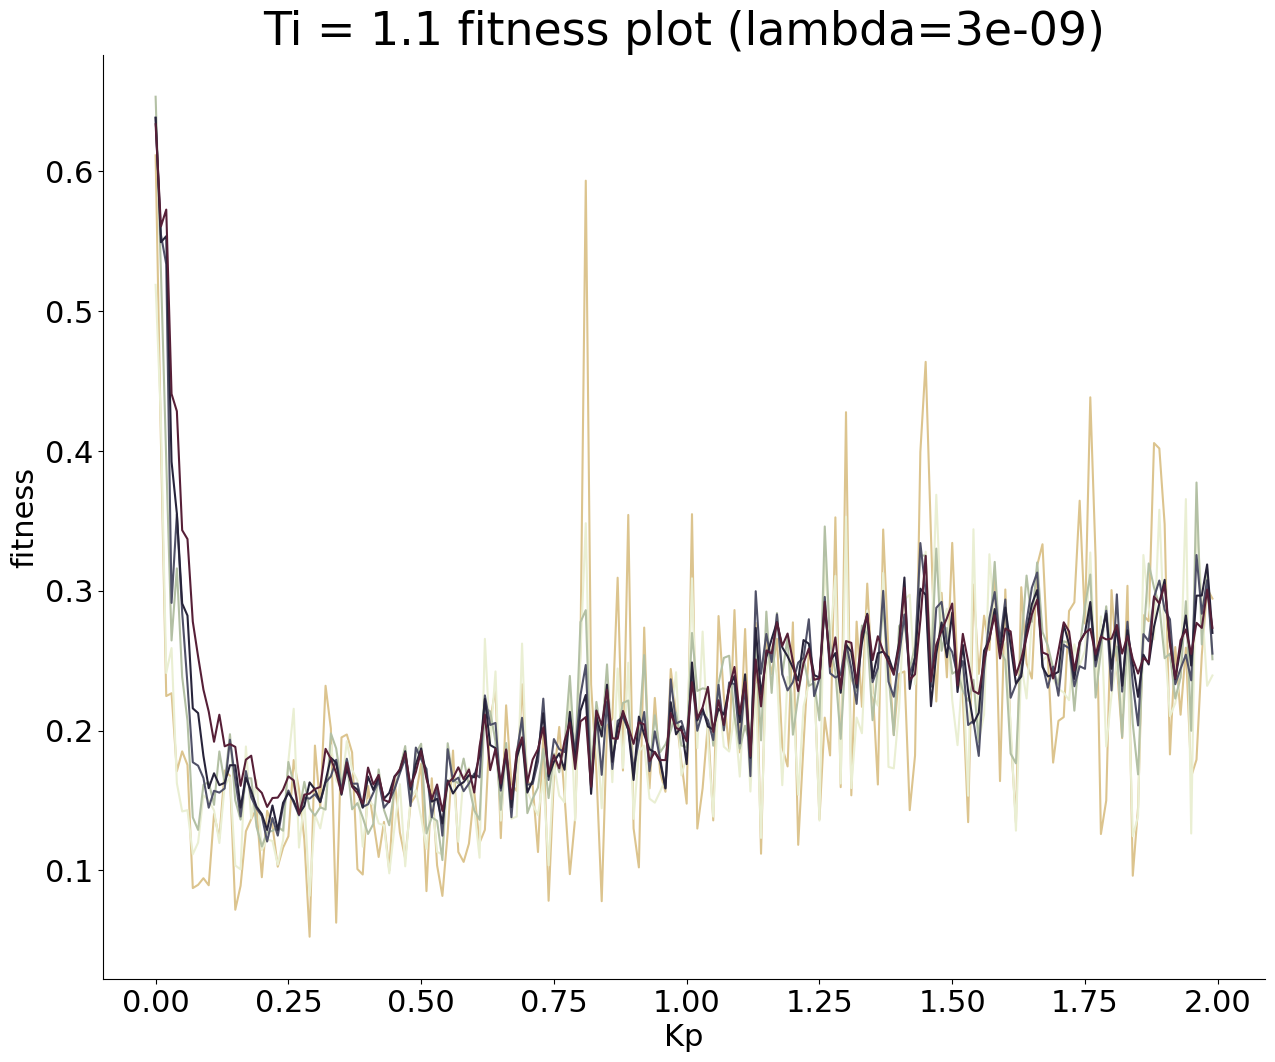

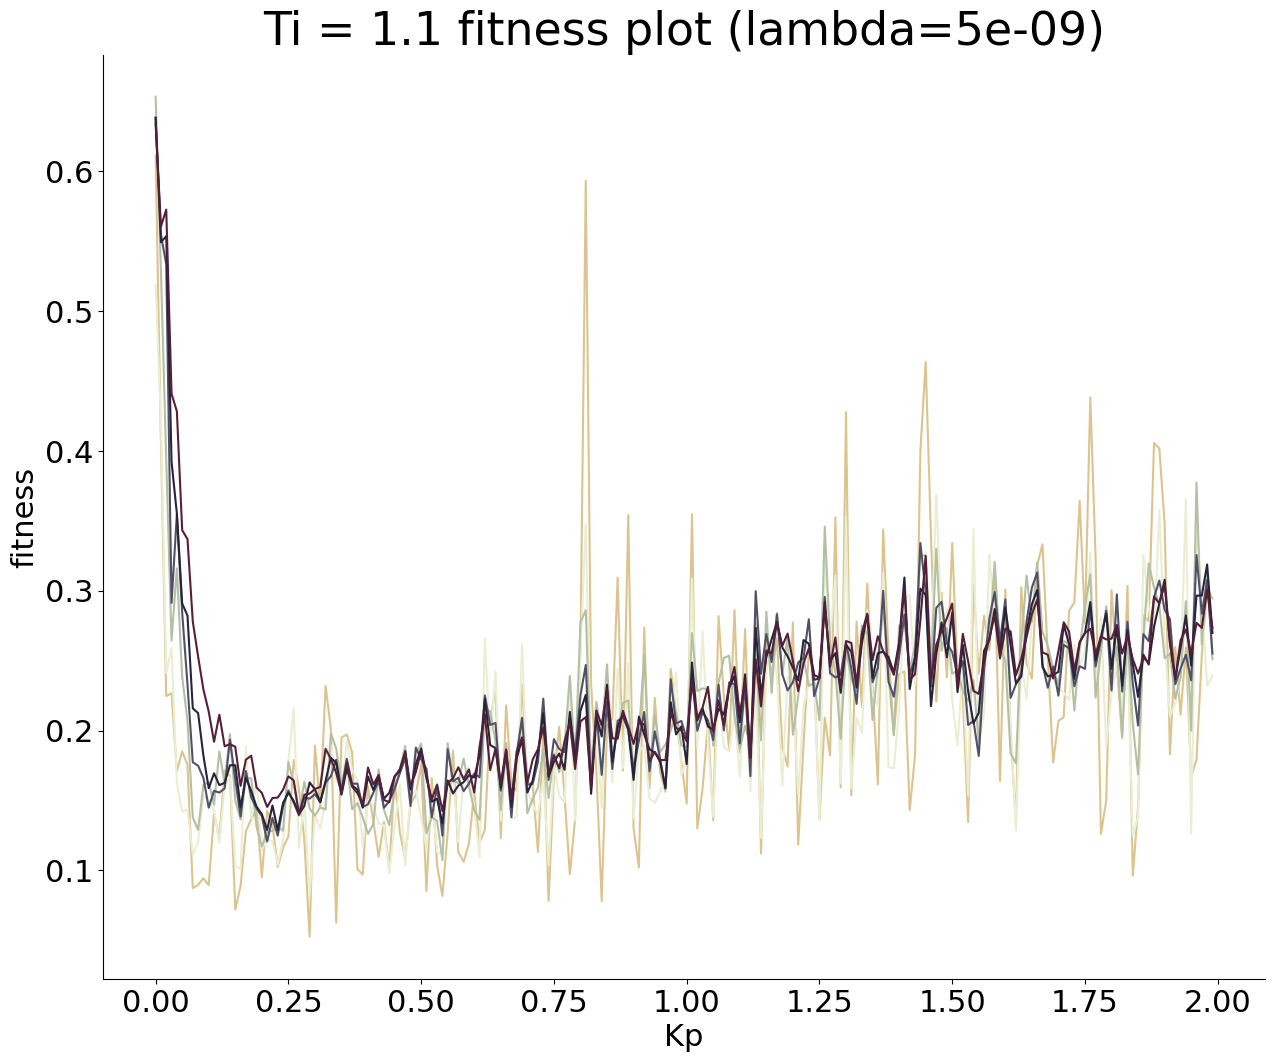

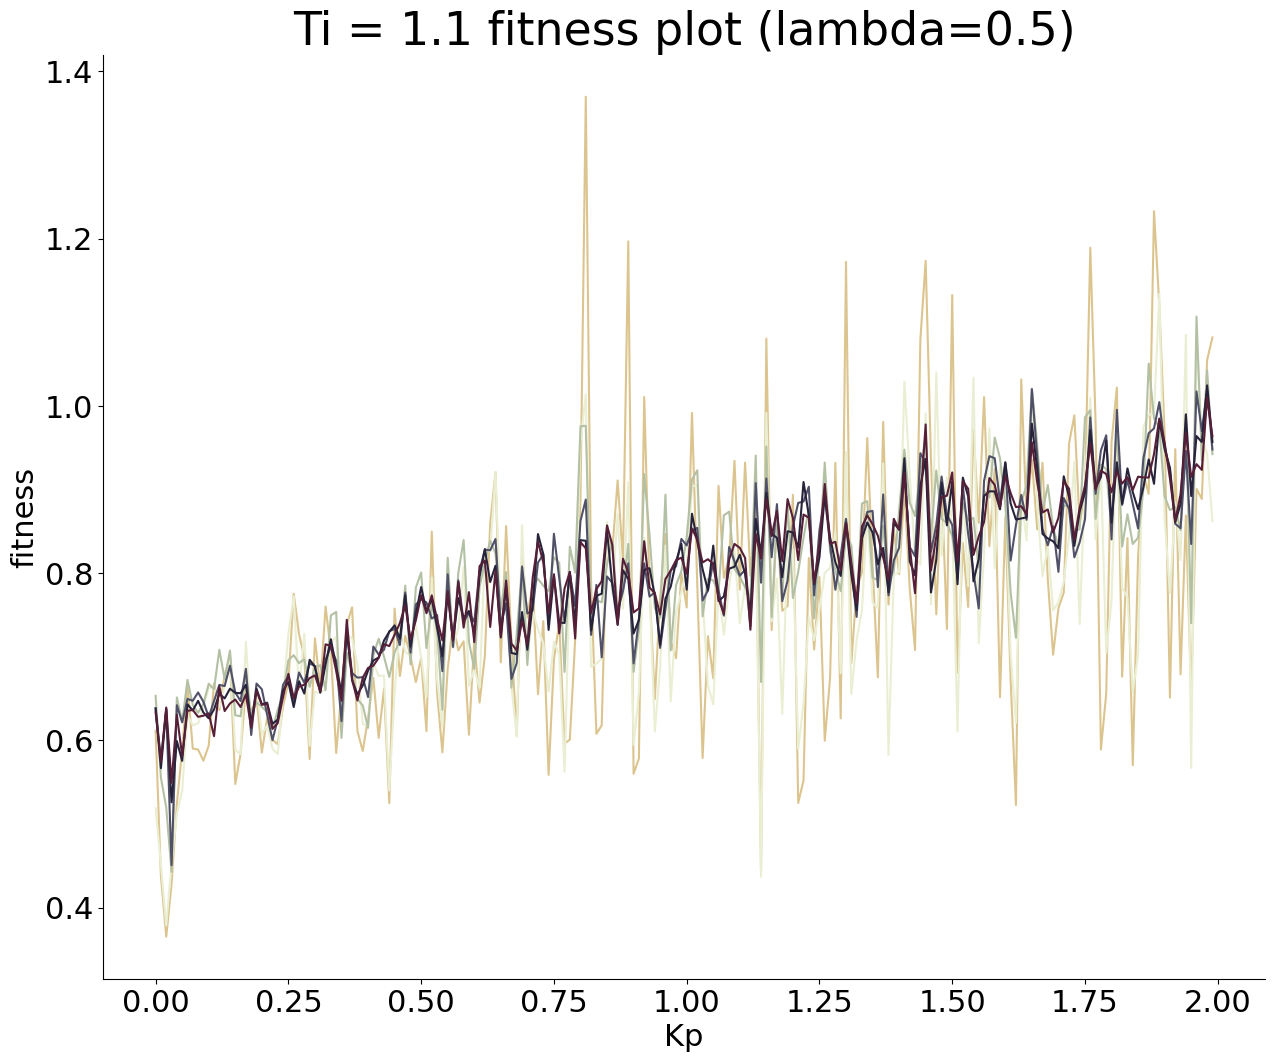

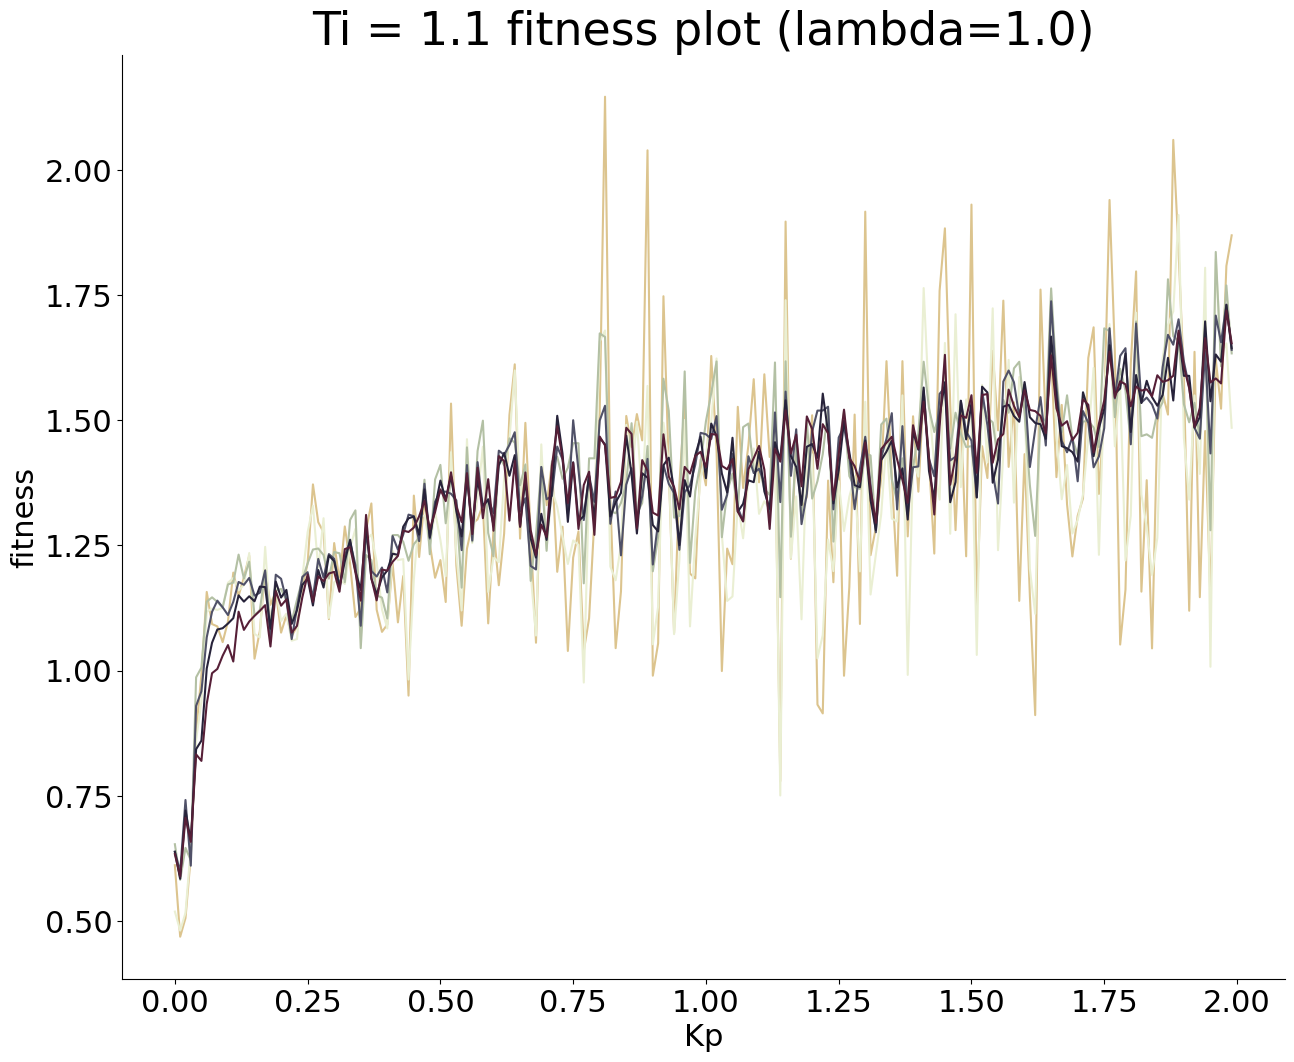

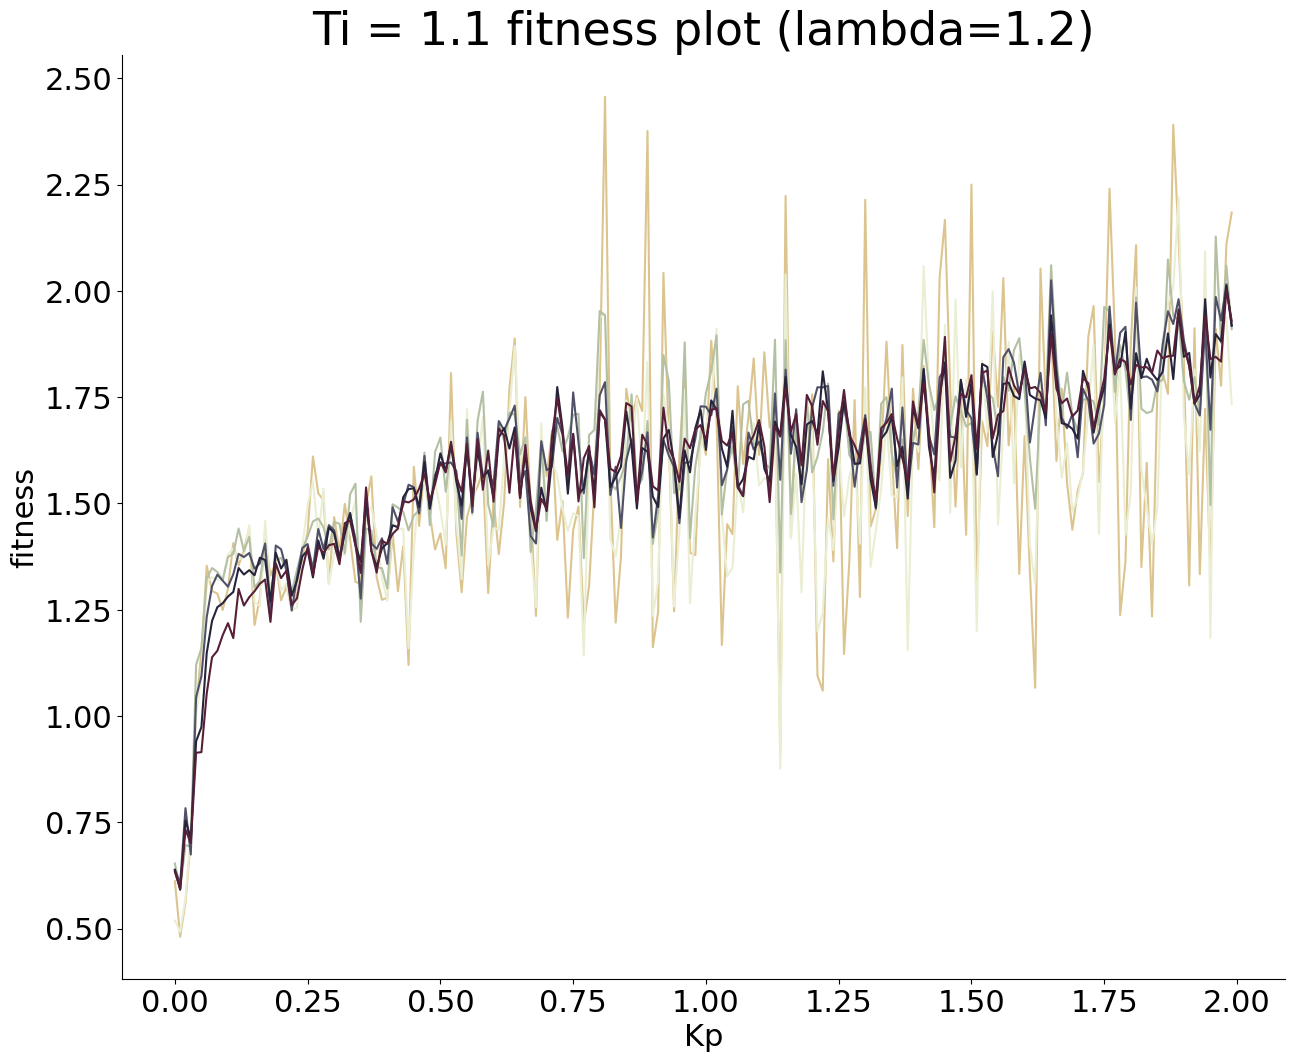

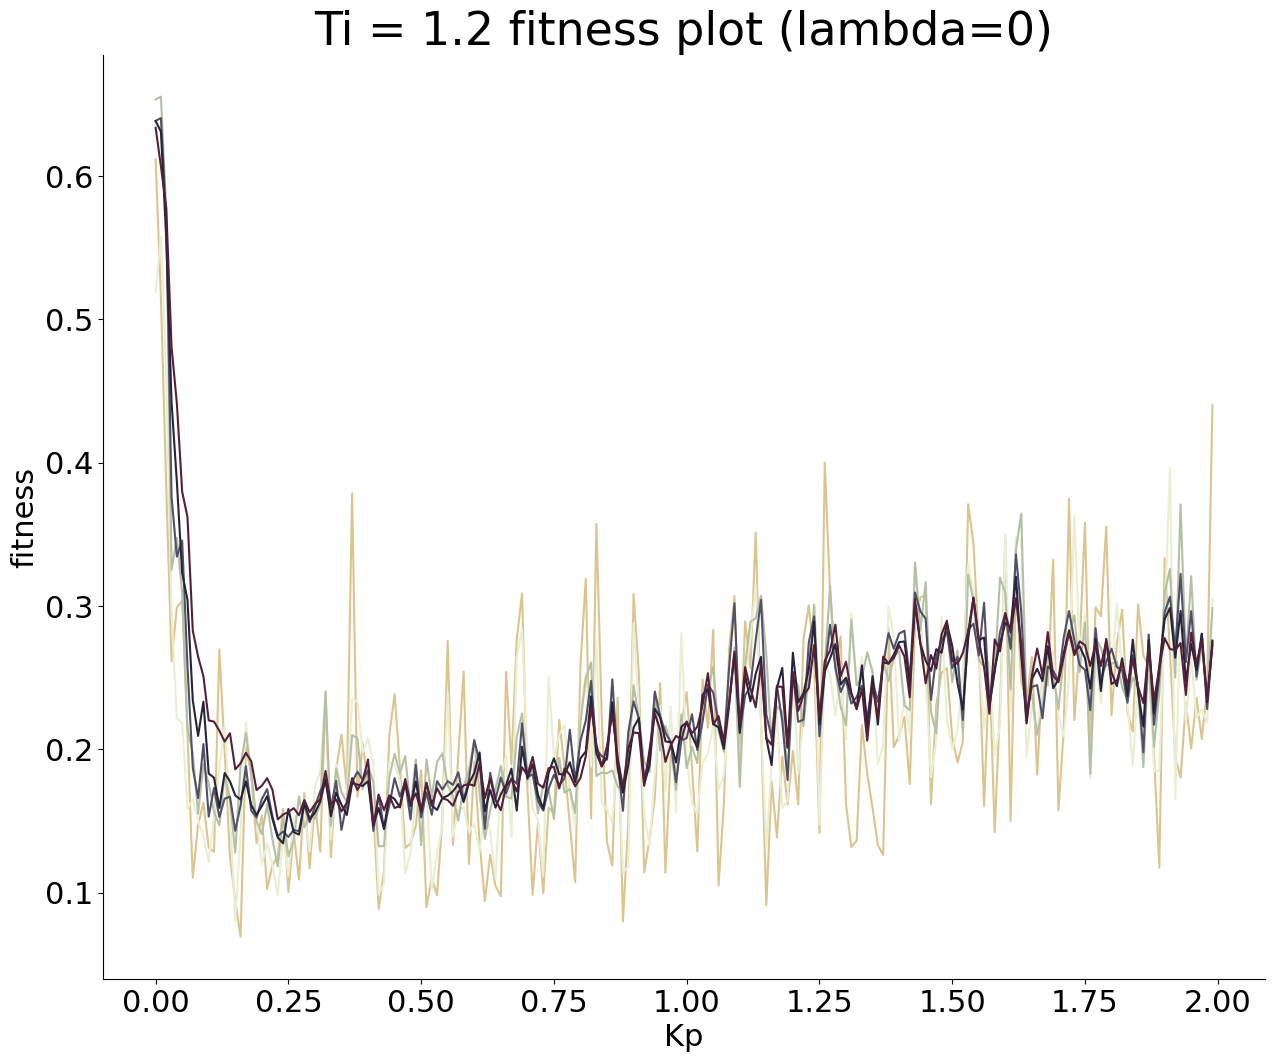

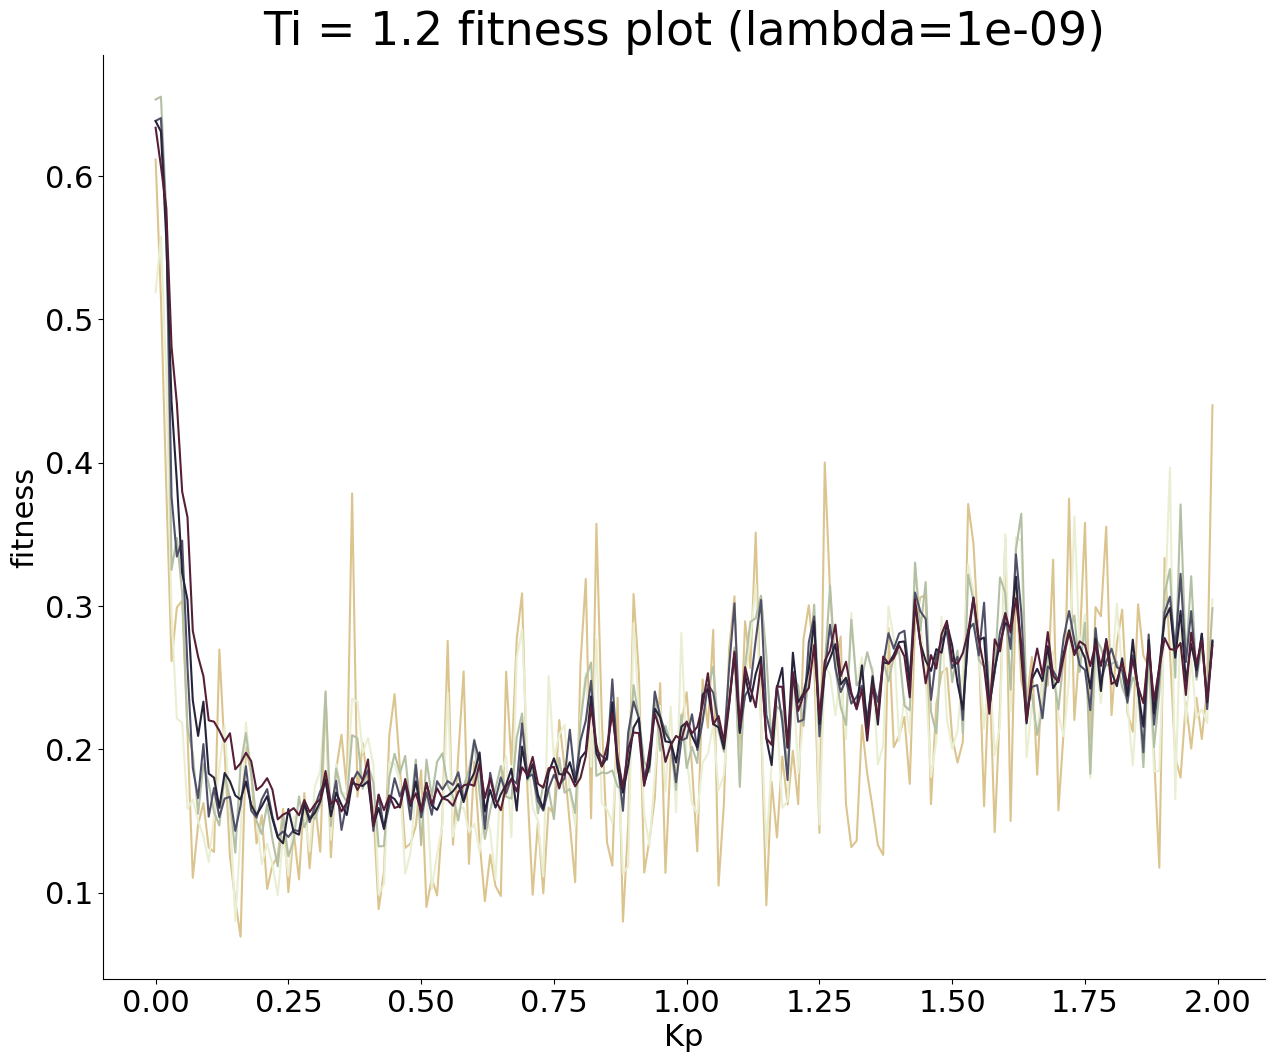

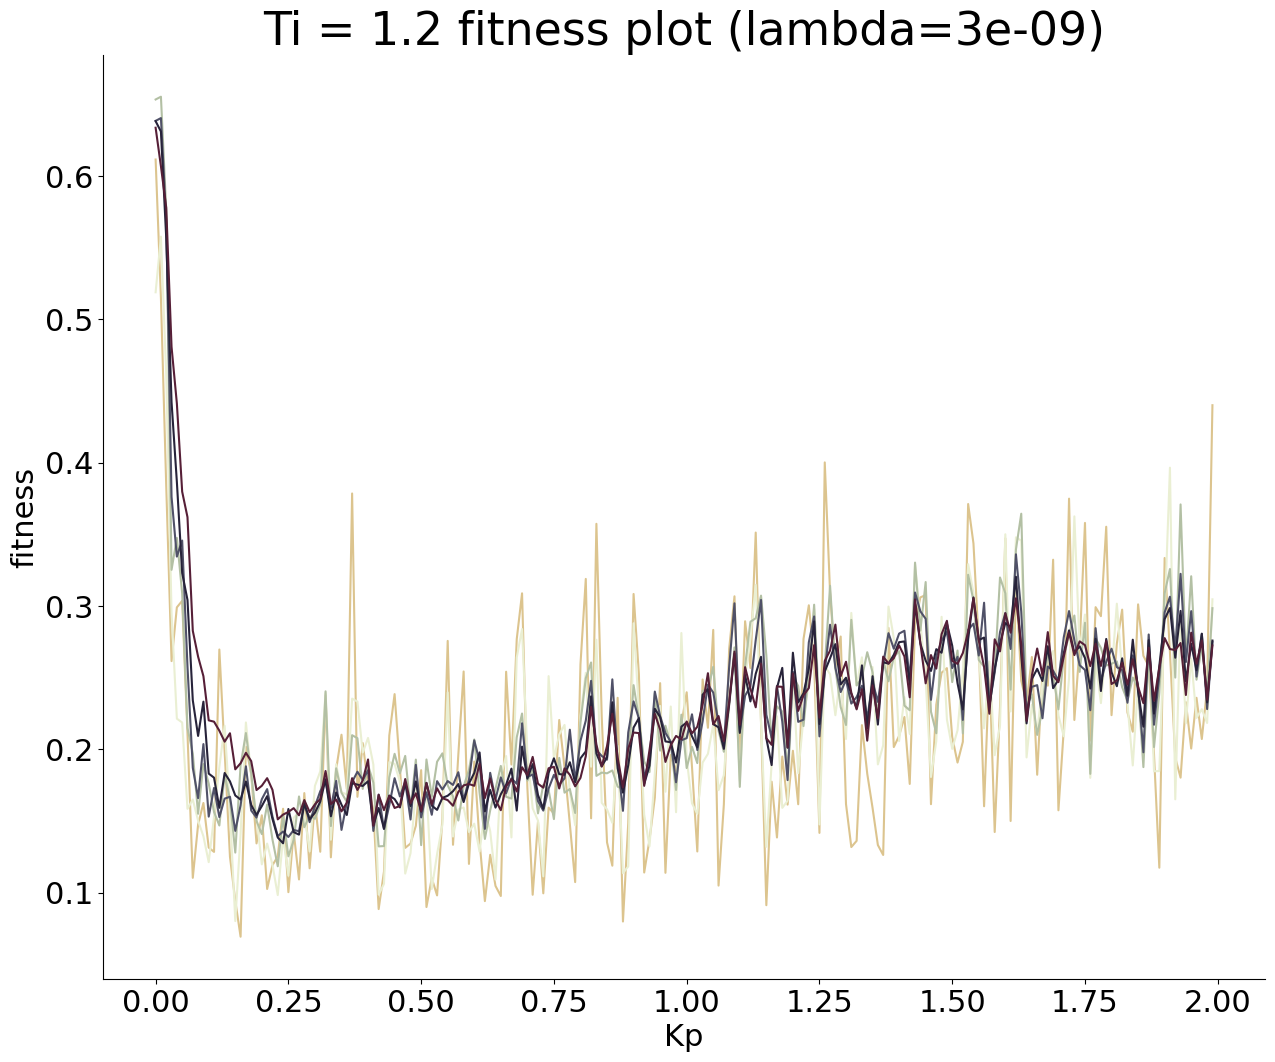

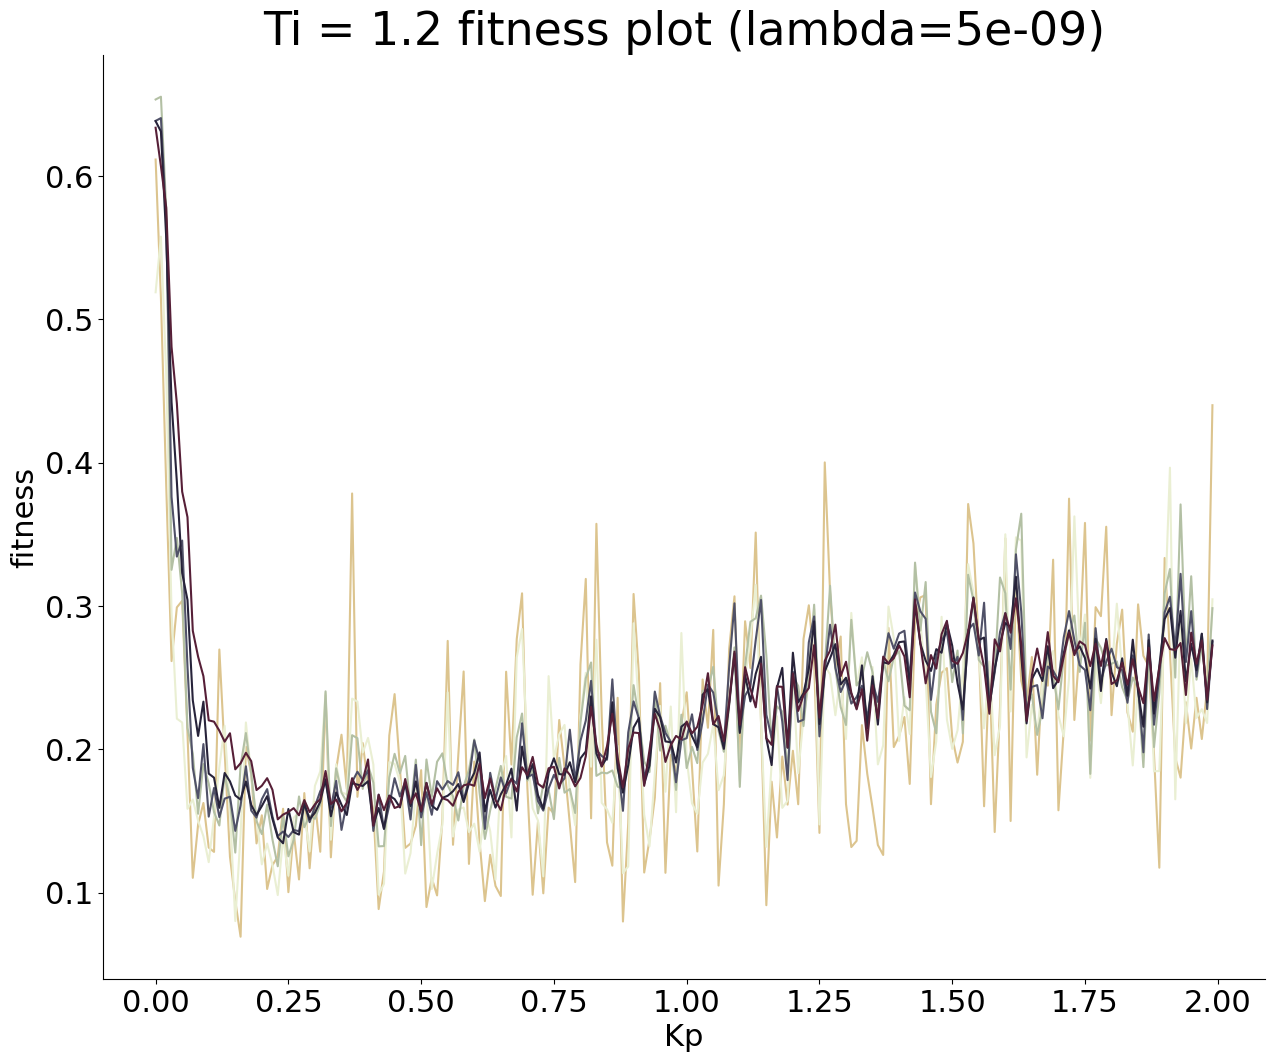

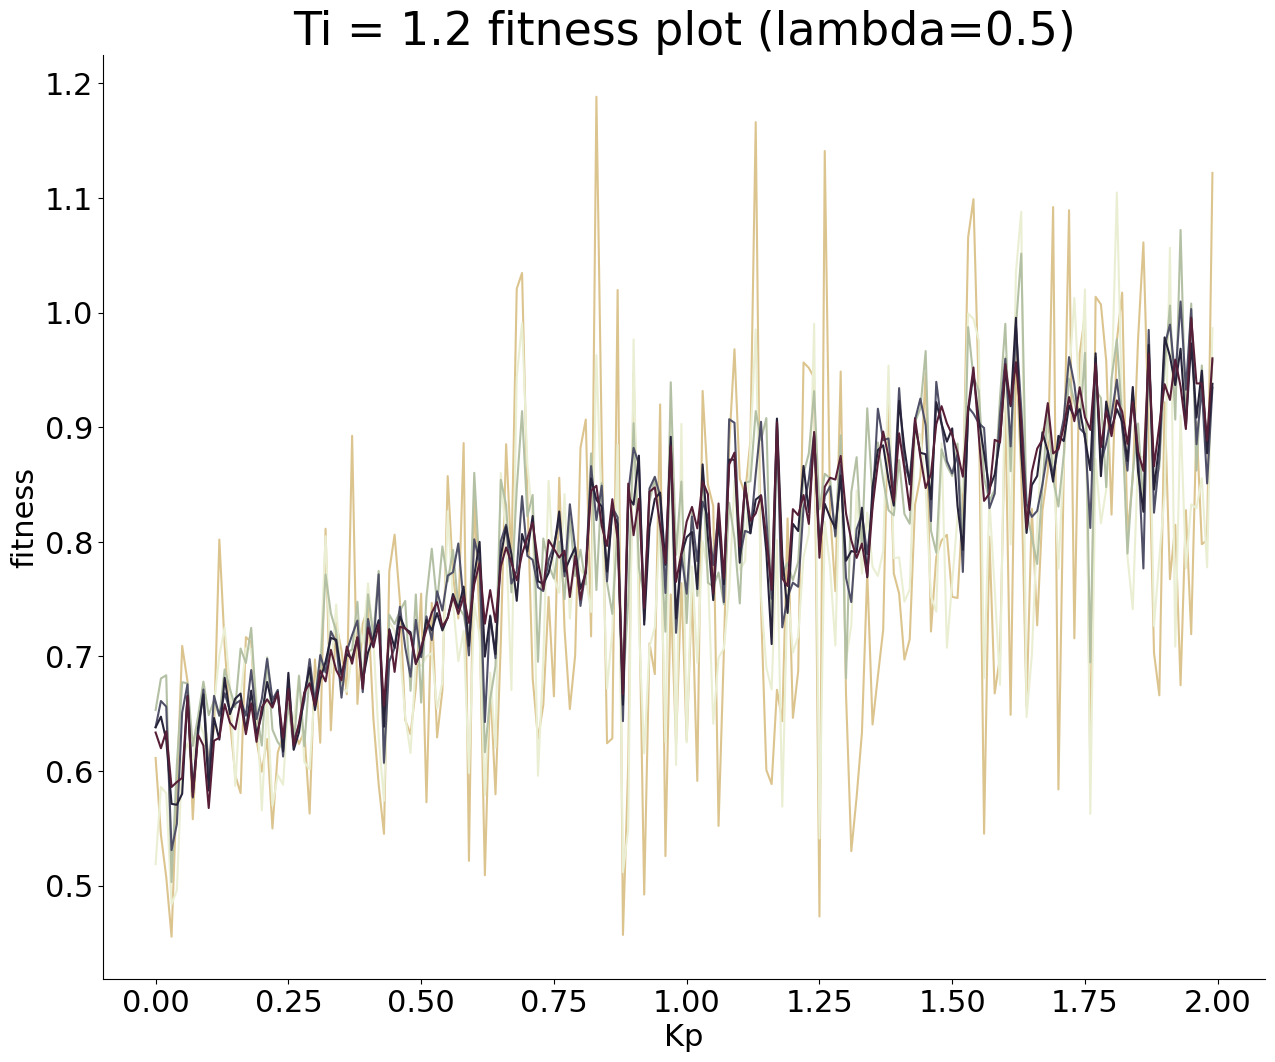

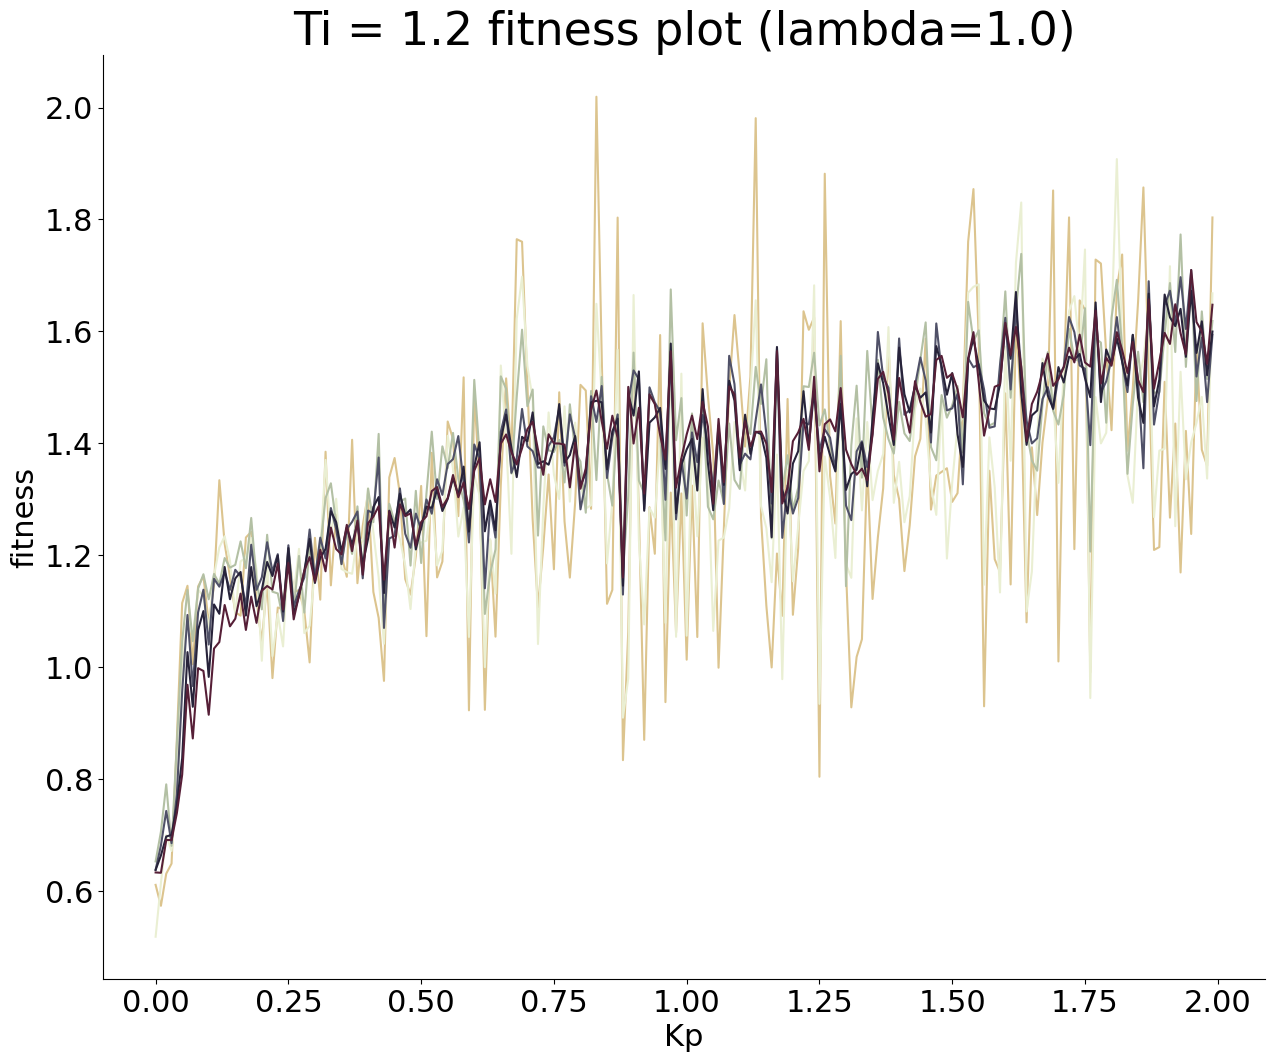

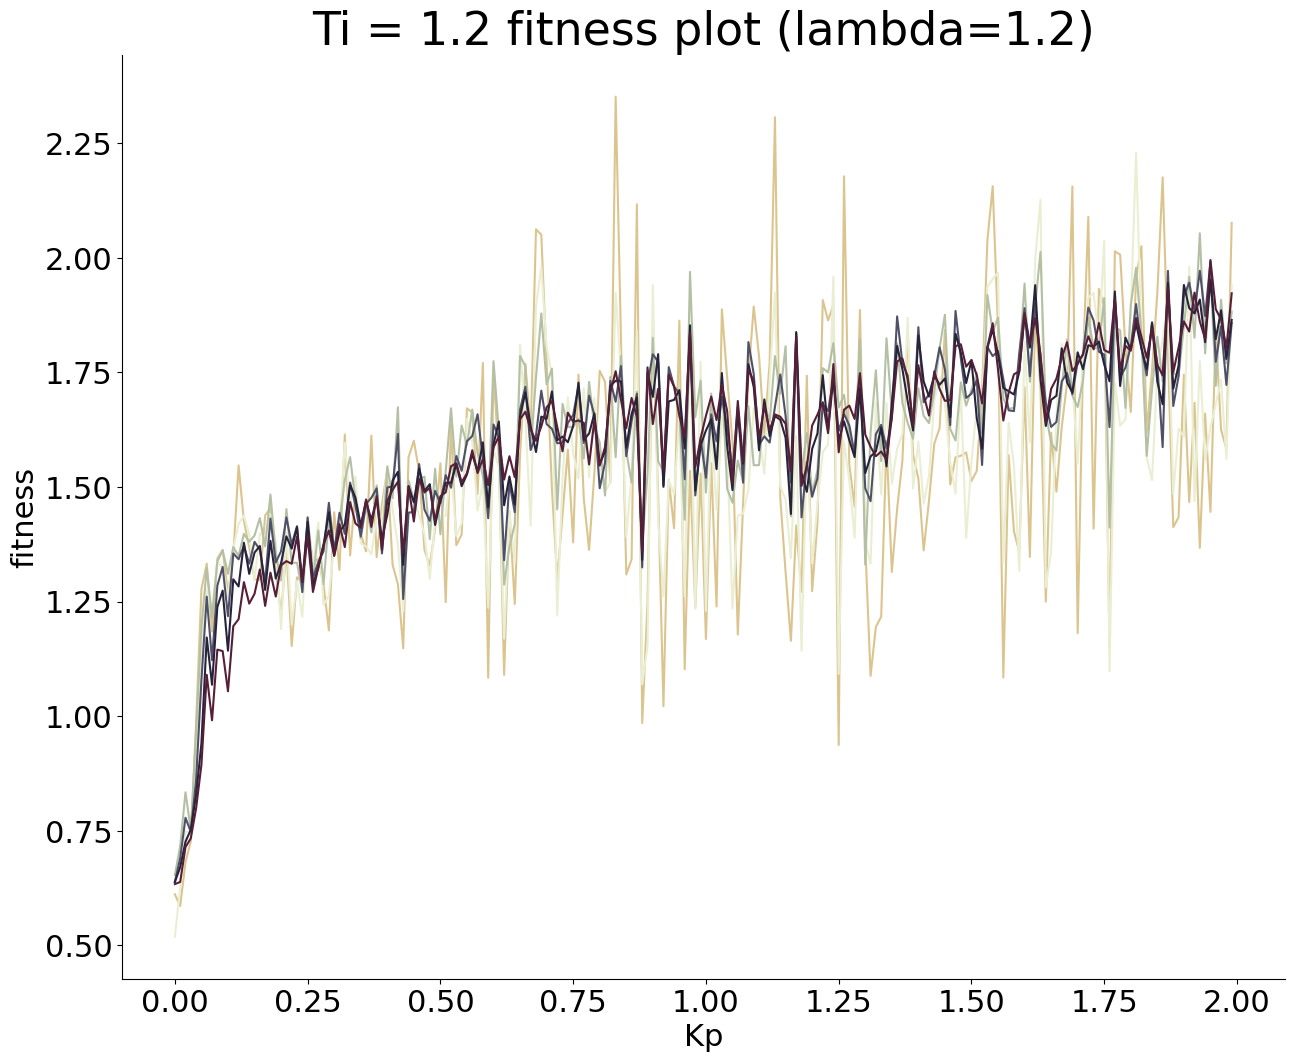

In [5]:
for plotted in tqdm(['MSE', 'TEED', 'fitness']):
    for ti in [1.1, 1.2]:
        if plotted == 'fitness':
            lam_list = [0, 1e-9, 3e-9, 5e-9, 0.5, 1.0, 1.2]
        else:
            lam_list = [0]
        for i_lam, lam in enumerate(lam_list):
            results = compute_fitness(results_dir, lam)
            plot_fitness_slice(results, plotted, ti, lam, i_lam, 'exponential')
            
            

In [6]:
lam_list = [0, 1e-09, 5e-09, 0.1, 0.5, 0.8, 1.0, 1.2]
tail_len = 15000
plotted = 'fitness'
selected_ti = 1.1

fitness_data = dict()

for lam in lam_list:
    results = compute_fitness(results_dir, lam)
    dtypes = [('ti', float), ('kp', float), ('mse', float), ('teed', float), ('j', float)]
    a = np.array(results[tail_len], dtype=dtypes)
    a.sort(order=['ti', 'kp'])
    kp, j = list(zip(*[(e[1], e[-1]) for e in a if e[0] == selected_ti]))
    fitness_data[lam] = {
        'kp': kp,
        'fitness': j
    }

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [13]:
# dir_1d = Path('ift_zero_target_1d')
dir_1d = Path('ift_1d')

g_dict = dict()

# lam_list = [5e-09]

lam_list = [0, 1e-9, 5e-9, 0.5, 1.0, 1.2]

for lam in lam_list:
    g_k = []
    g_v = []
    g_v_r = []

    for d in dir_1d.iterdir():
        if not d.is_dir():
                continue
        for output_file in d.glob('*.out'):
            output_text = output_file.read_text()
            config = u.read_config_from_output_file(output_file)
            if config['ti'] != 1.1:
                continue
            if config['lam'] != lam:
                continue
            matches = re.findall("Gradient: \[\s*([-+0-9e\.]+)\s+([-+0-9e.]*)\s*\]", output_text)
            matches_r = re.findall("R-scaled gradient: \[\s*([-+0-9e\.]+)\s+([-+0-9e.]*)\s*\]", output_text)
            print(f"lambda = {lam}, kp = {config['kp']:.2f}, gradient = {matches[0][0]}, r-scaled: {matches_r[0][0]}")
            g_k.append(config['kp'])
            g_v.append(float(matches[0][0]))
            g_v_r.append(float(matches_r[0][0]))
    if len(g_k) > 1:
        g_k, g_v, g_v_r = zip(*sorted(zip(g_k, g_v, g_v_r)))
    g_dict[lam] = {
        'g_k': g_k,
        'g_v': g_v,
        'g_v_r': g_v_r
    }

lambda = 0, kp = 0.04, gradient = -7.86410171, r-scaled: -9.1761465e-06
lambda = 0, kp = 0.14, gradient = -2.25636277, r-scaled: -4.32073372e-05
lambda = 0, kp = 0.24, gradient = -1.2739236, r-scaled: -6.28528096e-05
lambda = 0, kp = 0.34, gradient = -0.8938851, r-scaled: -9.25744562e-05
lambda = 0, kp = 0.44, gradient = -0.55740048, r-scaled: -0.00010337
lambda = 0, kp = 0.54, gradient = -0.59687494, r-scaled: -0.00014339
lambda = 0, kp = 0.64, gradient = -0.50933118, r-scaled: -0.0001585
lambda = 0, kp = 0.74, gradient = -0.49905929, r-scaled: -0.00017315
lambda = 0, kp = 0.84, gradient = -0.39882735, r-scaled: -0.0001868
lambda = 0, kp = 0.94, gradient = -0.36855224, r-scaled: -0.00021876
lambda = 0, kp = 1.04, gradient = -0.30021172, r-scaled: -0.00034521
lambda = 1e-09, kp = 0.05, gradient = -7.66265101, r-scaled: -1.10347091e-05
lambda = 1e-09, kp = 0.15, gradient = -3.11292333, r-scaled: -3.13667526e-05
lambda = 1e-09, kp = 0.25, gradient = -1.27272122, r-scaled: -6.46897095e-05

In [14]:
from bisect import bisect_left
import matplotlib.patches as mpatches

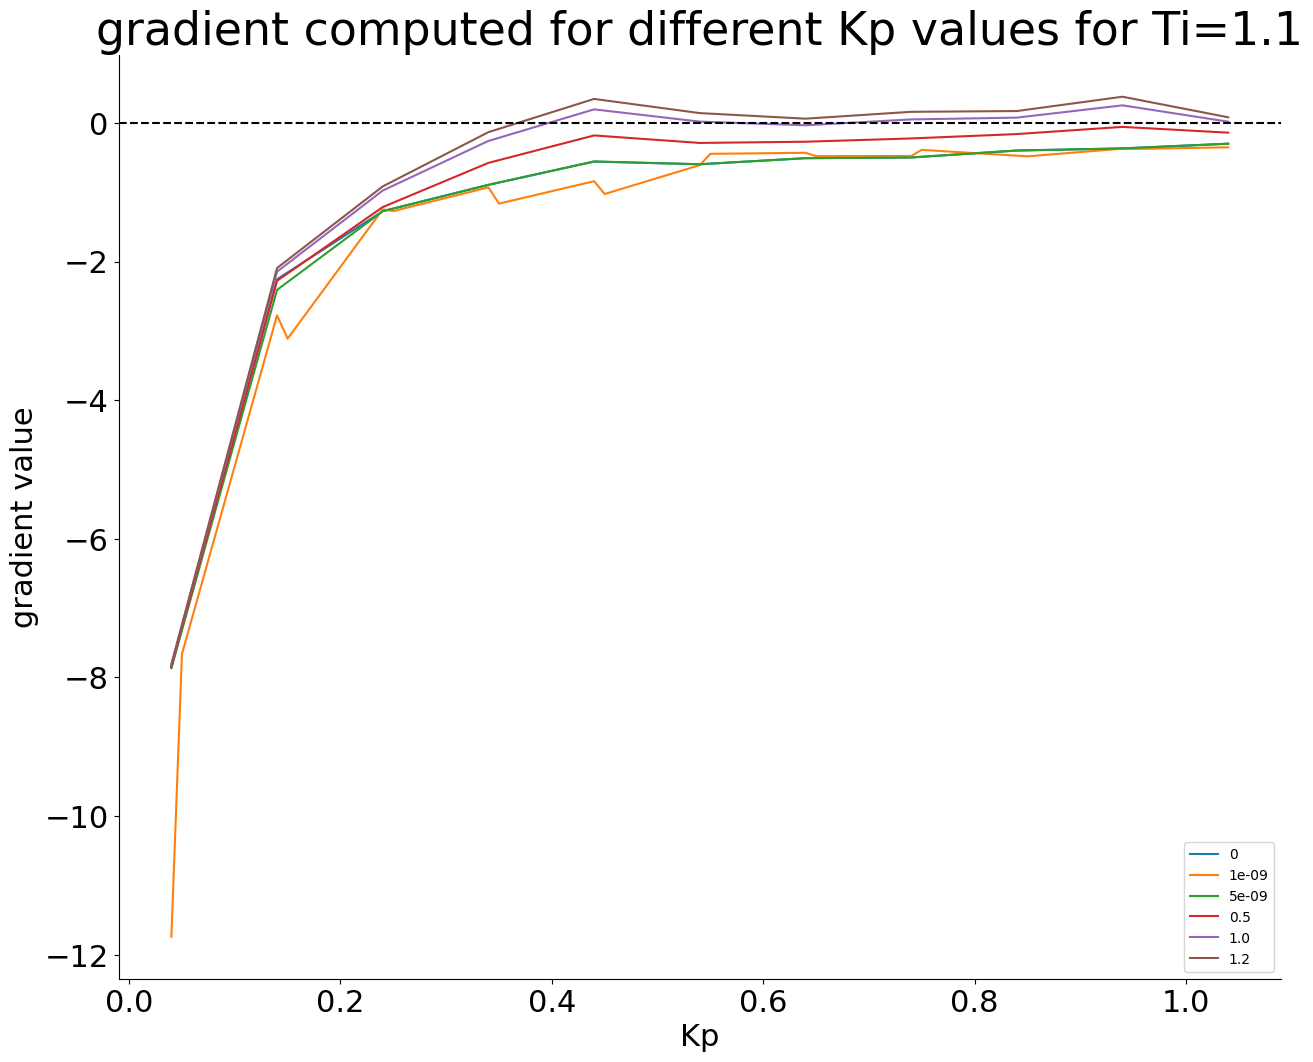

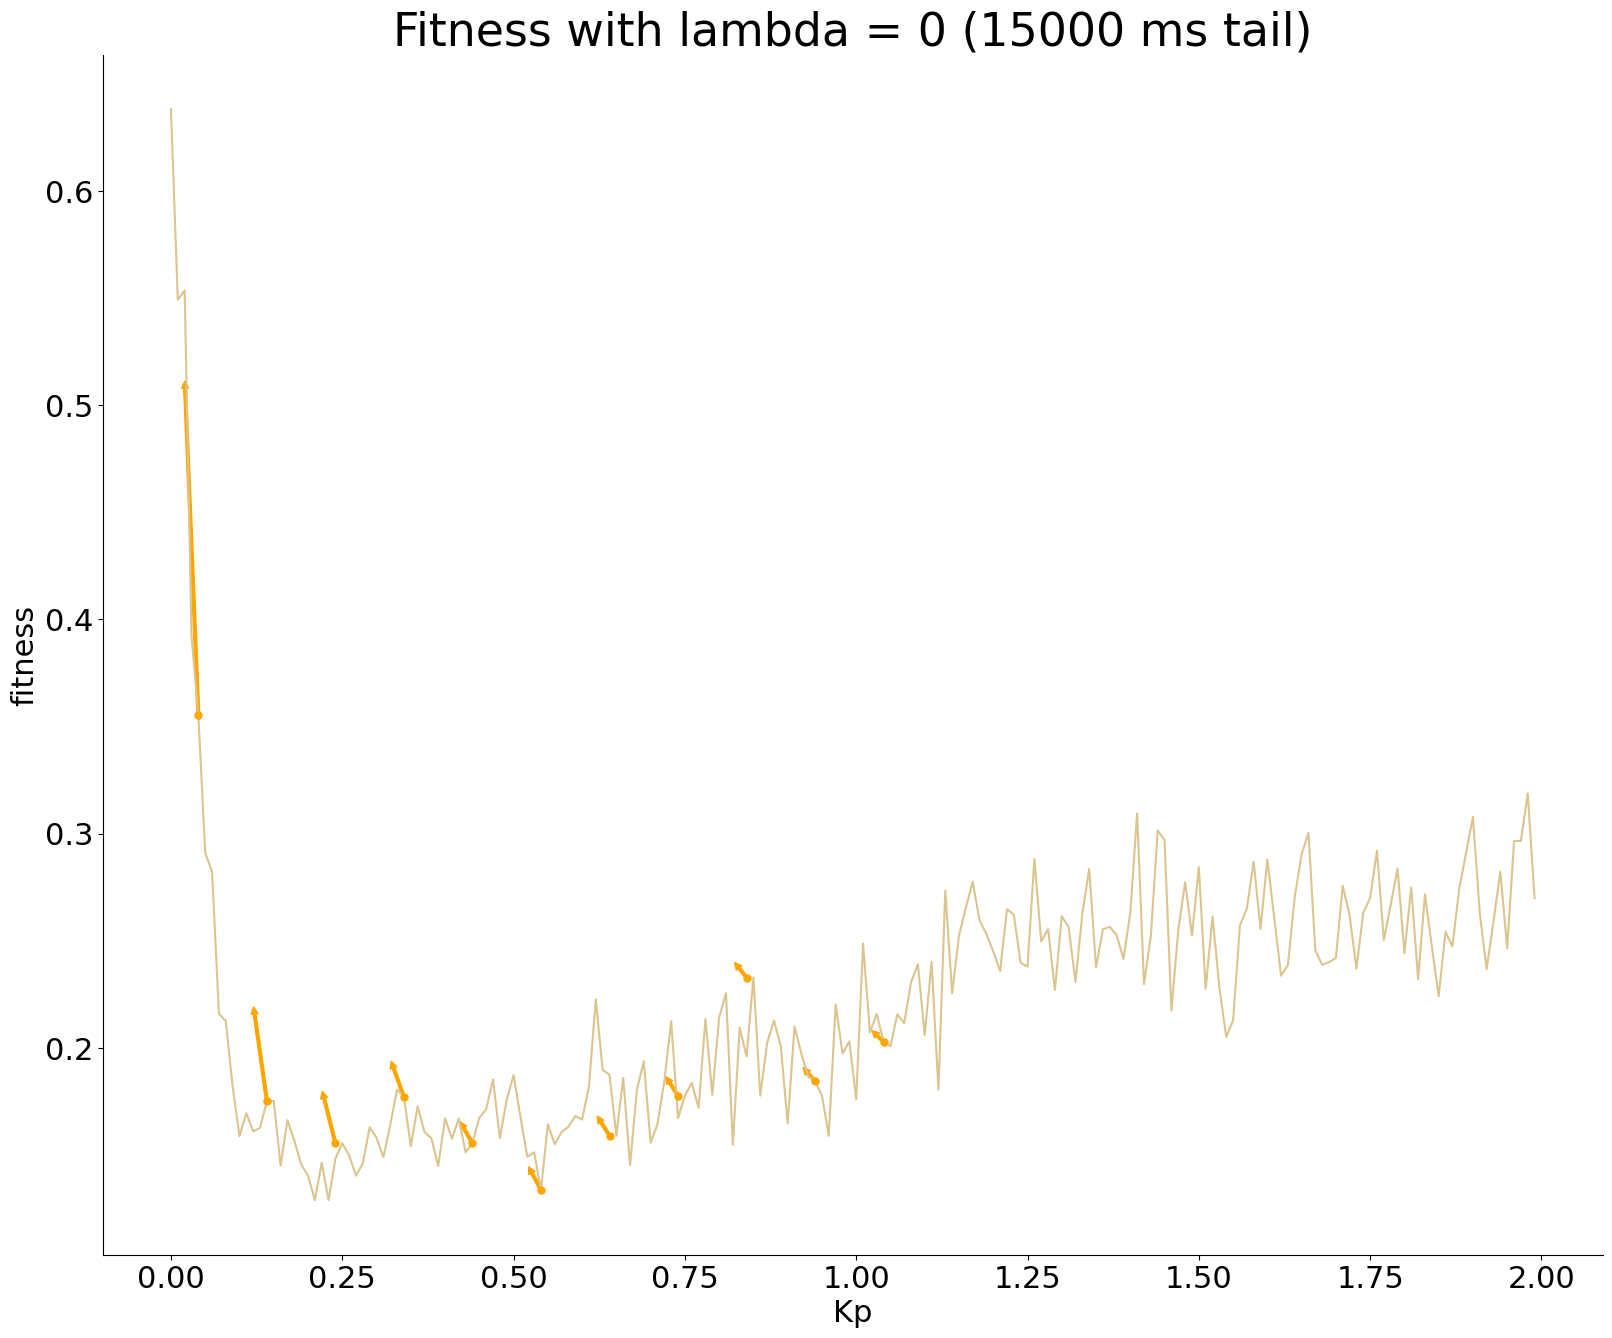

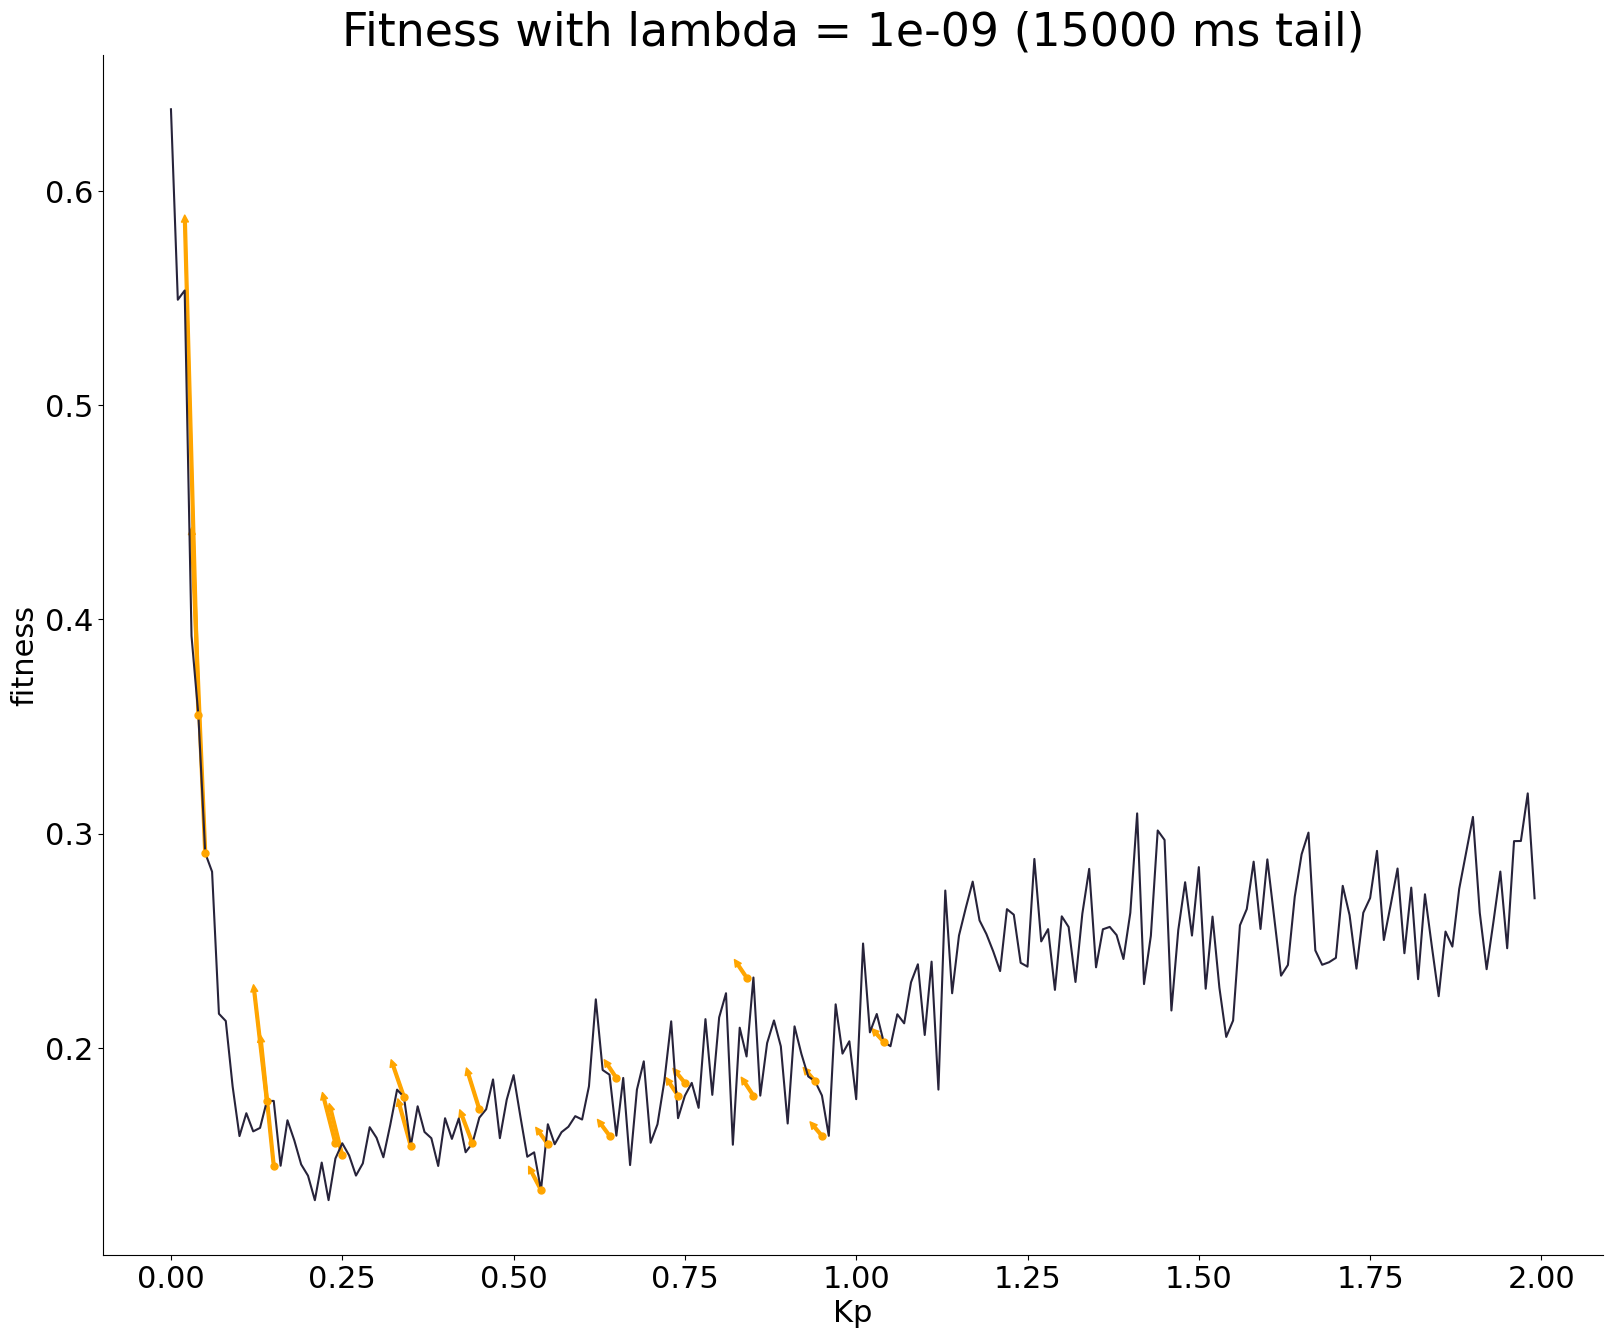

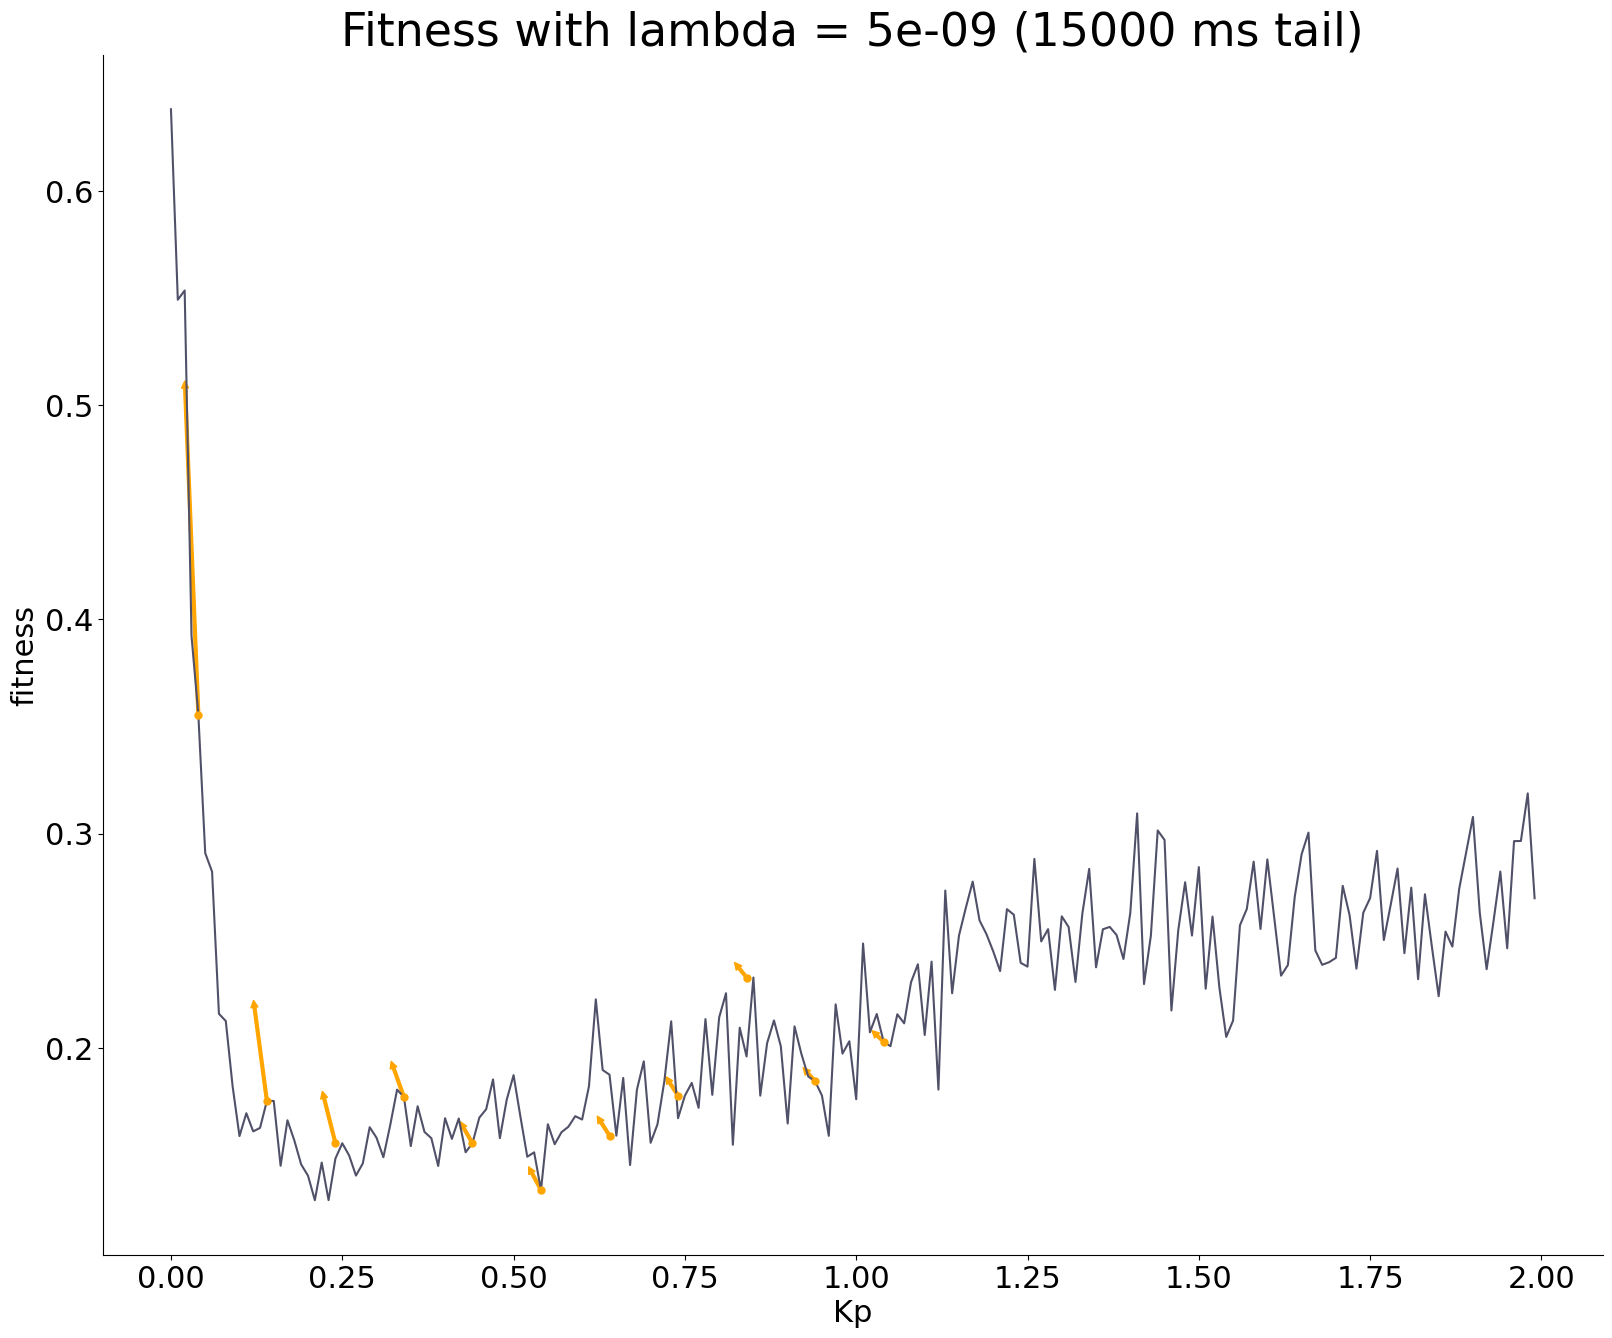

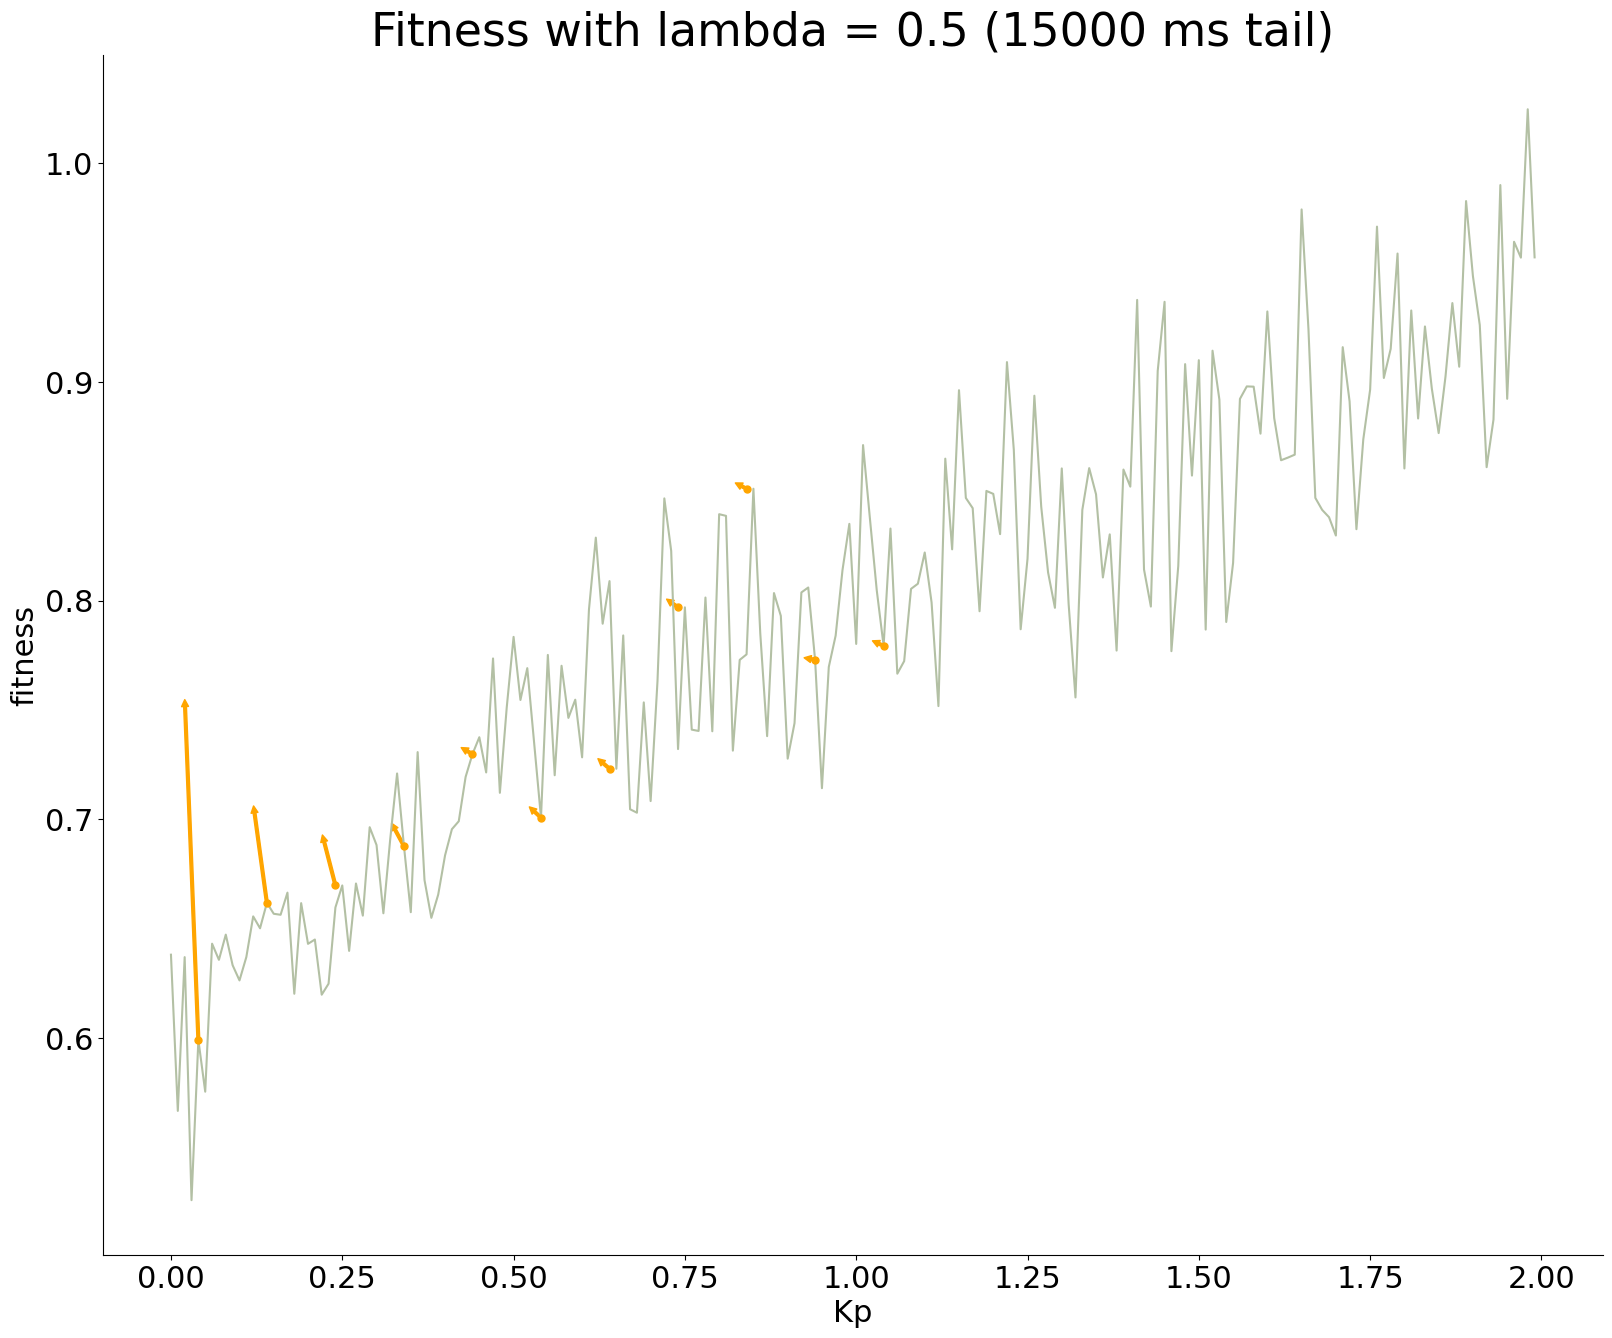

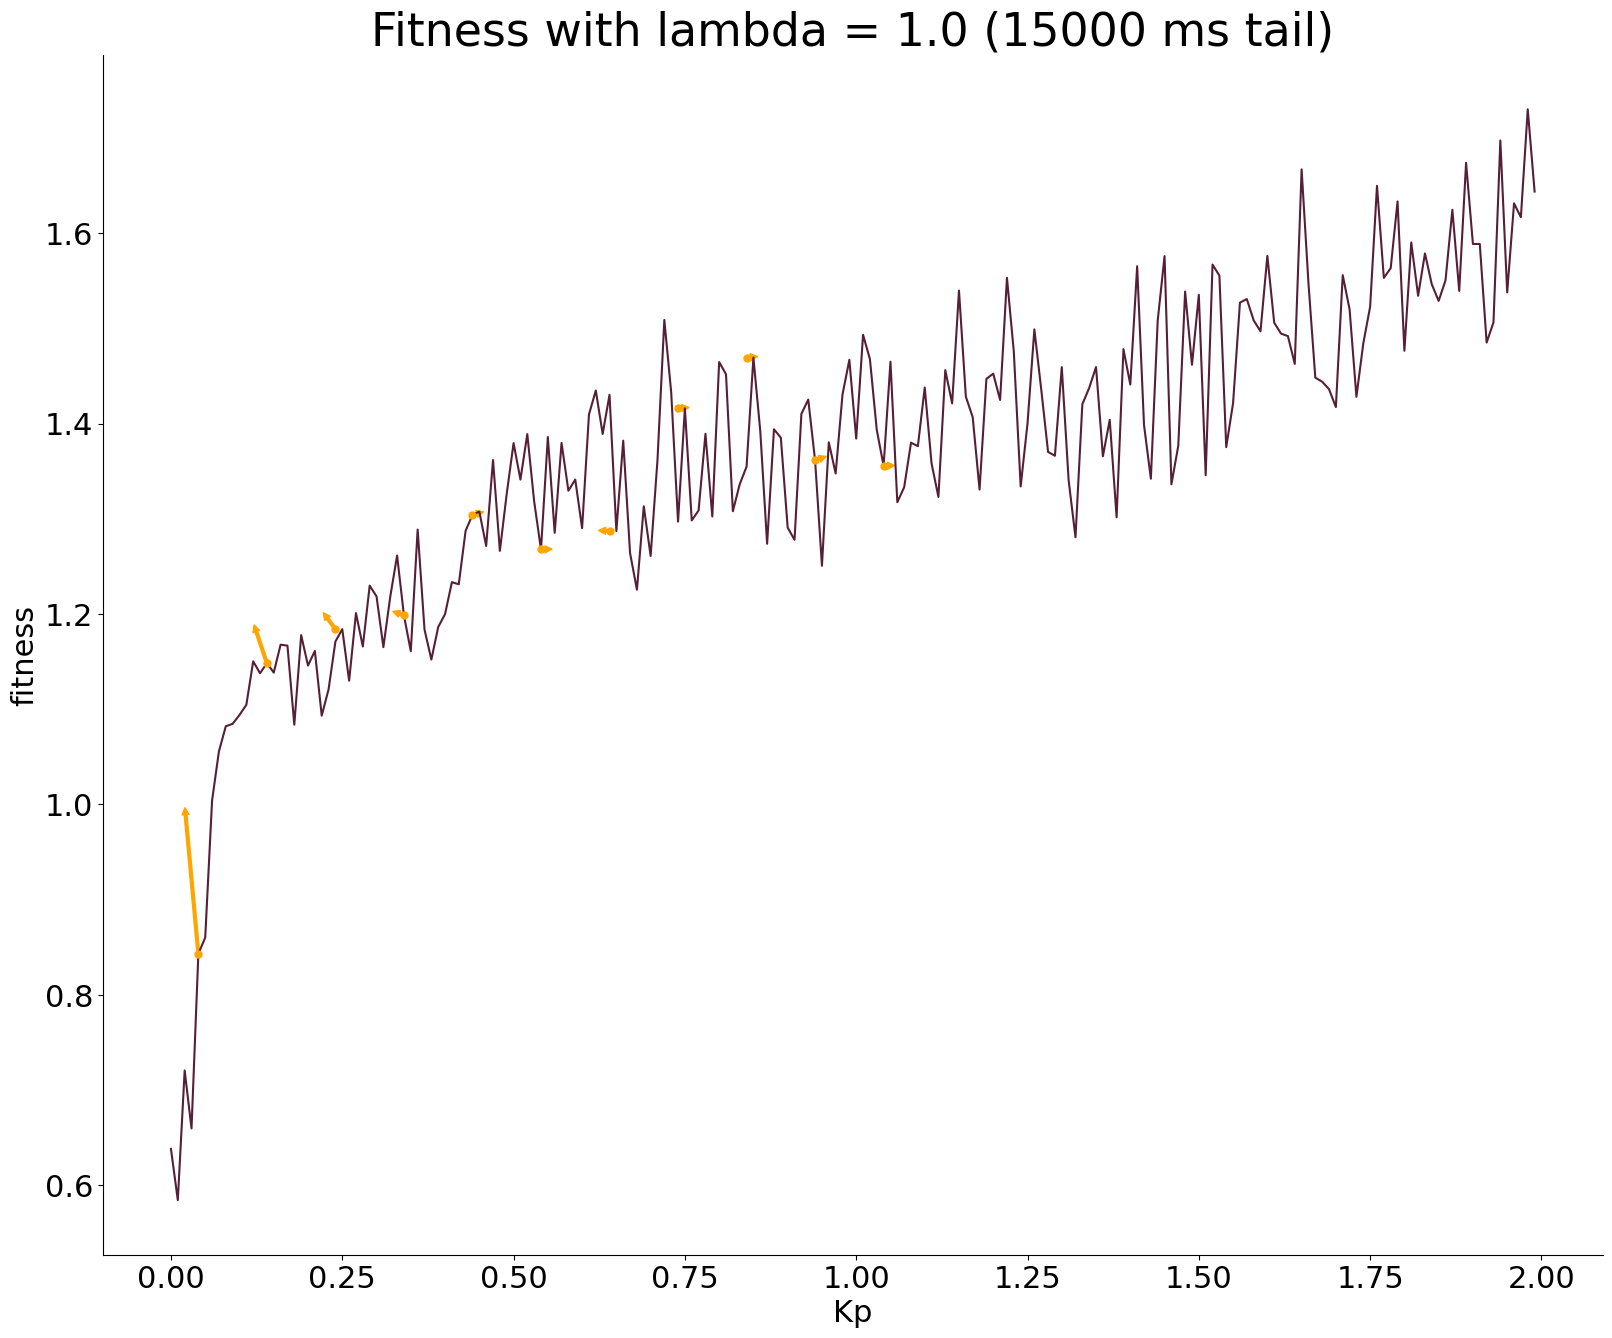

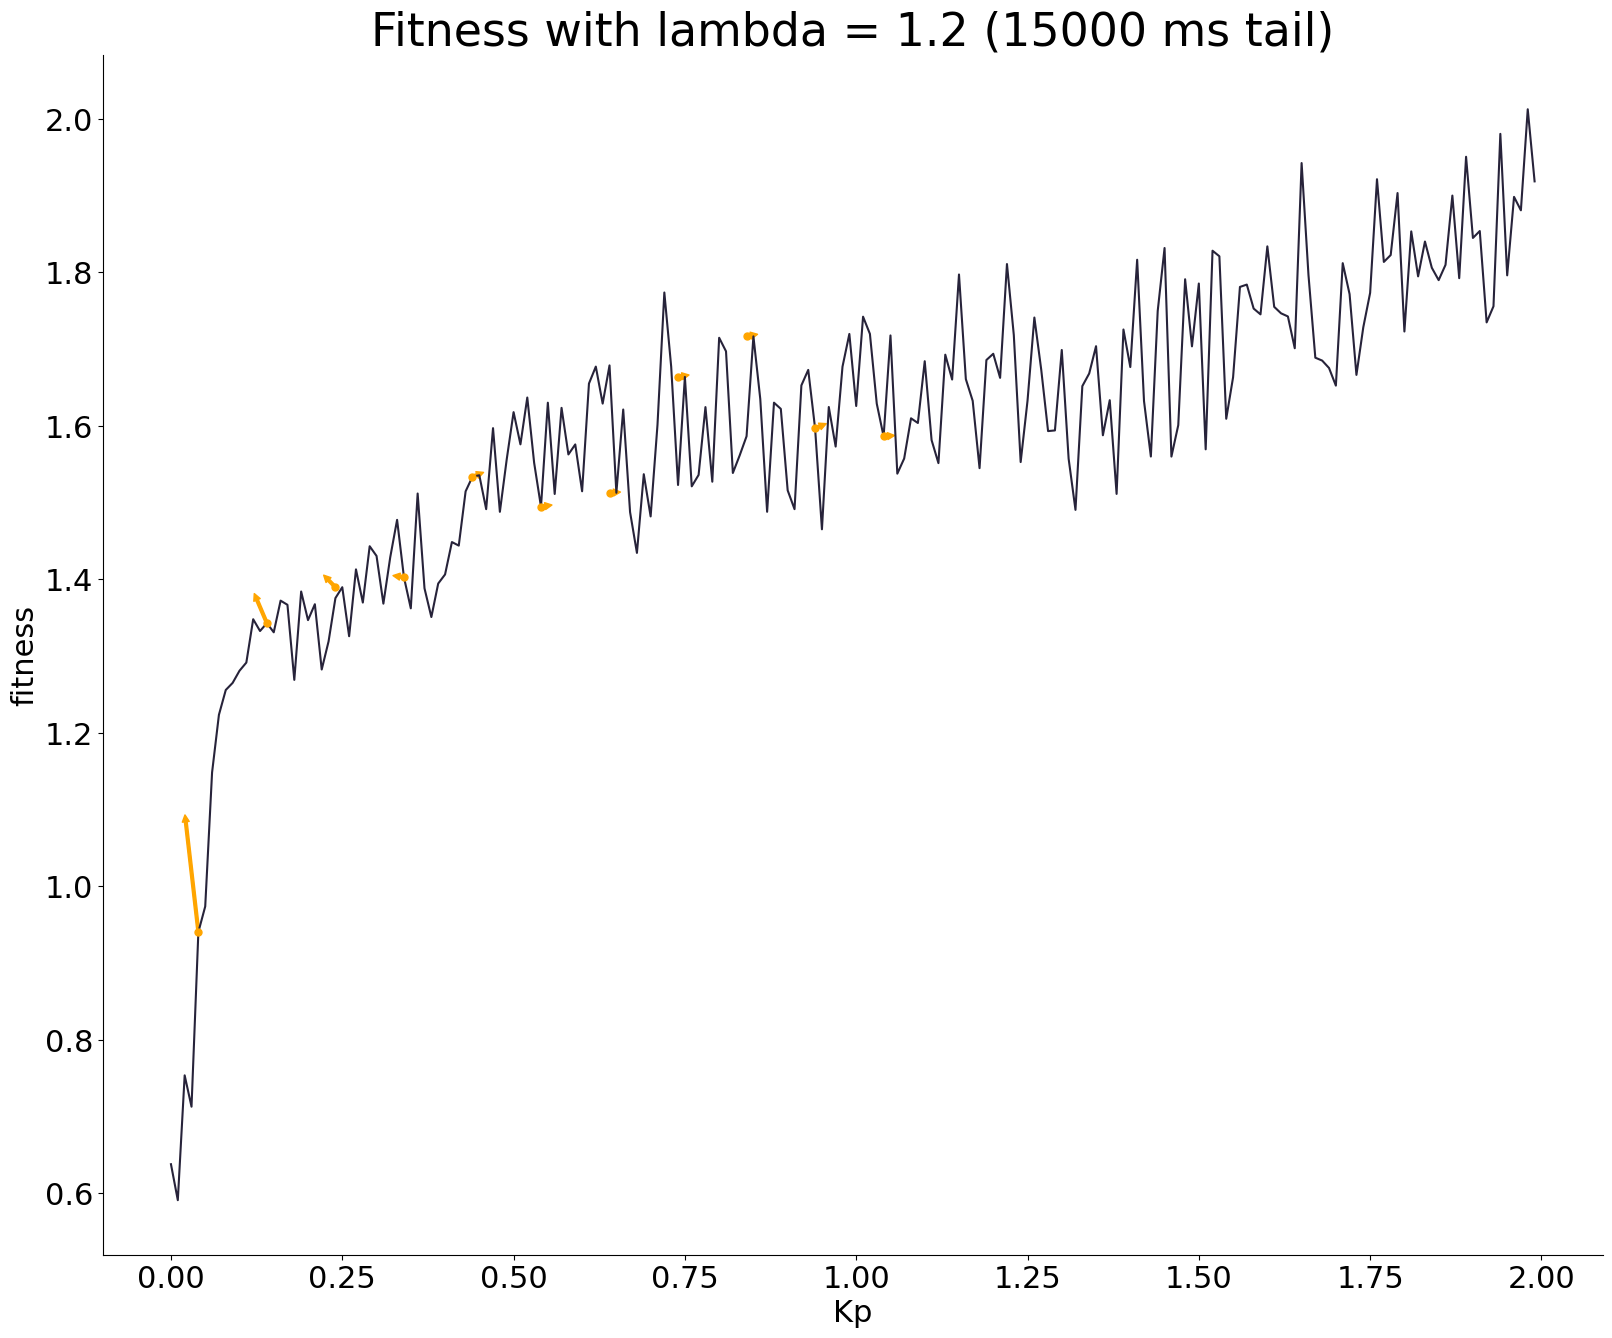

In [20]:
seg_len = 0.02
scaling_dict = {
    0: 1,
    1e-09: 1,
    5e-09: 1,
    0.1: 1,
    0.5: 1,
    0.8: 1,
    1.0: 1,
    1.2: 1
}
scaling_r = 1

fig = plt.figure(figsize=(15, 12))
for lam in lam_list:
    g_k = g_dict[lam]['g_k']
    g_v = g_dict[lam]['g_v']
    plt.plot(g_k, g_v)
ax = fig.axes[0]
ax.axhline(0, linestyle='--', color='black')
ax.legend(lam_list)
u.format_single_2d_plot(fig, 'Kp', 'gradient value', 'gradient computed for different Kp values for Ti=1.1')



for j, lam in enumerate(lam_list):
    kp = fitness_data[lam]['kp']
    fitness = fitness_data[lam]['fitness']
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_axes([0, 0, 1, 1])

    ax.plot(kp, fitness, color=line_colors[-j])
    
    g_k = g_dict[lam]['g_k']
    g_v = g_dict[lam]['g_v']
    g_v_r = g_dict[lam]['g_v_r']
    
    scaling = scaling_dict[lam]
    for i in range(len(g_k)):
        gradient = g_v[i] / scaling
        gradient_r = g_v_r[i] / scaling_r
        val = fitness[bisect_left(kp, g_k[i])]
        tail_x = g_k[i]
        tail_y = val
        head_x = tail_x + np.sign(gradient) * seg_len
        head_y = tail_y + np.abs(gradient) * seg_len

        ax = fig.axes[0]
        ax.add_patch(mpatches.FancyArrowPatch((tail_x, tail_y), (head_x, head_y), color='orange', mutation_scale=10))
        ax.plot(g_k[i], val, '.', color="orange", markersize=10)
        # if lam == 1e-09:
        #     ax.set_ylim([2e-9, 7e-9])
        # elif lam == 0:
        #     ax.set_ylim([0, 7e-9])
        # elif lam == 5e-09:
        #     ax.set_ylim([4e-9, 9e-9])

    u.format_single_2d_plot(fig, 'Kp', 'fitness', f'Fitness with lambda = {lam} ({tail_len} ms tail)')